Objective: To identify the most significant environmental and temporal factors that influence household appliance energy consumption, and to use these factors to develop an accurate and interpretable machine learning model for energy usage prediction.

First step: Clean the dataset and display a clean version

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score

file_path = "KAG_energydata_complete.csv"
df = pd.read_csv(file_path)
df.head()
df.shape






(19735, 29)

In [2]:
# Extract time-based features
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

# Drop the original date column
df.drop(columns=['date'], inplace=True)

In [3]:
# Separate features and target variable
X = df.drop(columns=['Appliances'])
y = df['Appliances']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

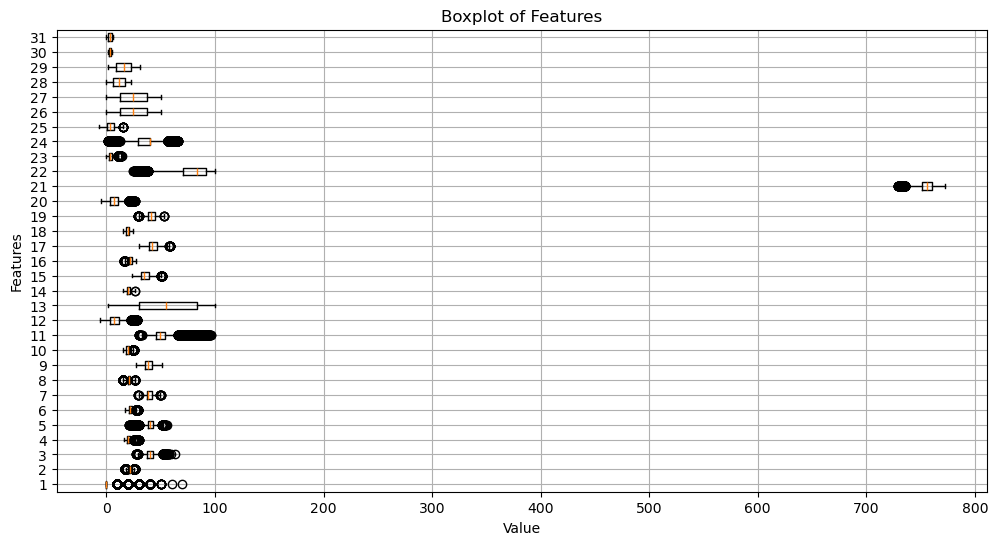

In [4]:
#Boxplot the features
plt.figure(figsize=(12, 6))
plt.boxplot(X, vert=False)
plt.title('Boxplot of Features')
plt.xlabel('Value')
plt.ylabel('Features')
plt.grid()
plt.show()


We can see a high volatilty on several features. Therefore, let's standardize the data to avoid these extreme values to influence our analysis.

In [5]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save feature names
feature_names = X.columns.tolist()

print(df.head(10))

   Appliances  lights         T1       RH_1     T2       RH_2     T3  \
0          60      30  19.890000  47.596667  19.20  44.790000  19.79   
1          60      30  19.890000  46.693333  19.20  44.722500  19.79   
2          50      30  19.890000  46.300000  19.20  44.626667  19.79   
3          50      40  19.890000  46.066667  19.20  44.590000  19.79   
4          60      40  19.890000  46.333333  19.20  44.530000  19.79   
5          50      40  19.890000  46.026667  19.20  44.500000  19.79   
6          60      50  19.890000  45.766667  19.20  44.500000  19.79   
7          60      50  19.856667  45.560000  19.20  44.500000  19.73   
8          60      40  19.790000  45.597500  19.20  44.433333  19.73   
9          70      40  19.856667  46.090000  19.23  44.400000  19.79   

        RH_3         T4       RH_4  ...     RH_out  Windspeed  Visibility  \
0  44.730000  19.000000  45.566667  ...  92.000000   7.000000   63.000000   
1  44.790000  19.000000  45.992500  ...  92.000000   

Next step: Create a Correlation matrix to understand the relationship between features in the dataset. 

This will help us answer the question of which environmental and time-based features have the most impact on appliance energy usage.

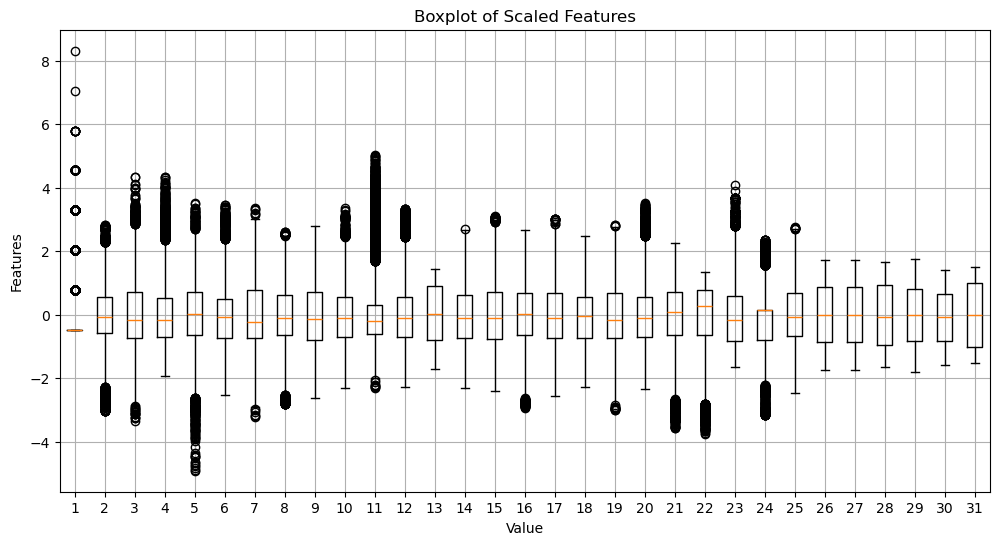

In [6]:
#Boxplot the scaled features
plt.figure(figsize=(12, 6))
plt.boxplot(X_train_scaled)
plt.title('Boxplot of Scaled Features')
plt.xlabel('Value')
plt.ylabel('Features')
plt.grid()
plt.show()


In [7]:
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['Appliances'].sort_values(ascending=False)

print("Top 10 features correlated with Appliances:")
print(correlation_with_target[1:11])

Top 10 features correlated with Appliances:
hour         0.216792
lights       0.197278
T2           0.120073
T6           0.117638
T_out        0.099155
Windspeed    0.087122
RH_1         0.086031
T3           0.085060
T1           0.055447
T4           0.040281
Name: Appliances, dtype: float64


To make it more visual we will create a plot of this data.

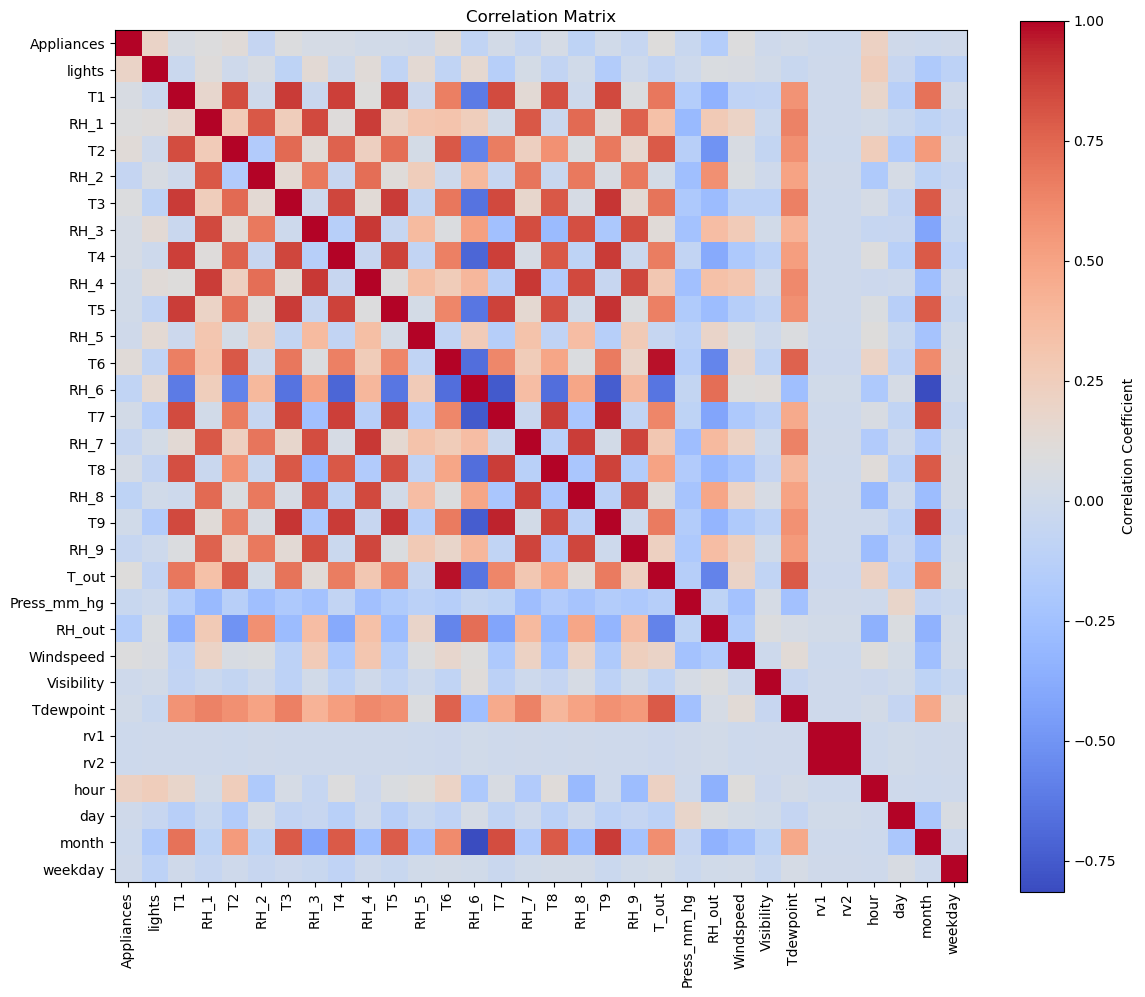

In [8]:
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')

tick_marks = np.arange(len(correlation_matrix.columns))
plt.xticks(tick_marks, correlation_matrix.columns, rotation=90)
plt.yticks(tick_marks, correlation_matrix.columns)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

To check how features affect model performance we will perform a Permutation Feature Importance test on the Random Forrest model

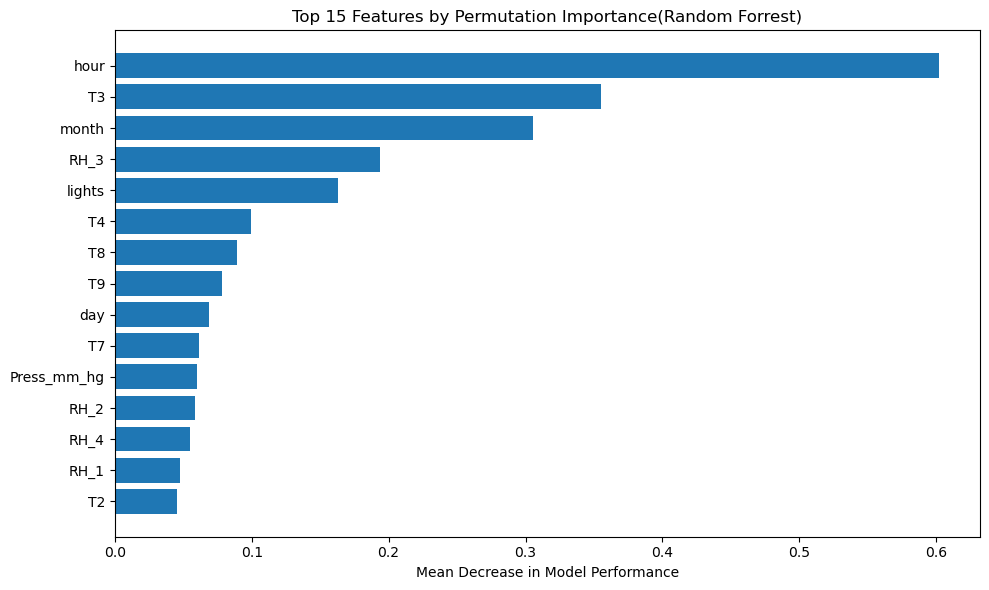

In [9]:
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_train_scaled, y_train)

result = permutation_importance(rf_model, X_test_scaled, y_test, n_repeats=5, random_state=42, n_jobs=-1)
rf_importances = result.importances_mean
indices = np.argsort(rf_importances)[::-1]
features = X.columns[indices]

plt.figure(figsize=(10, 6))
plt.barh(range(15), rf_importances[indices][:15], align='center')
plt.yticks(range(15), features[:15])
plt.xlabel("Mean Decrease in Model Performance")
plt.title("Top 15 Features by Permutation Importance(Random Forrest)")
plt.gca().invert_yaxis()  # Most important at the top
plt.tight_layout()
plt.show()

Next step is to do the same on the linear regression model.

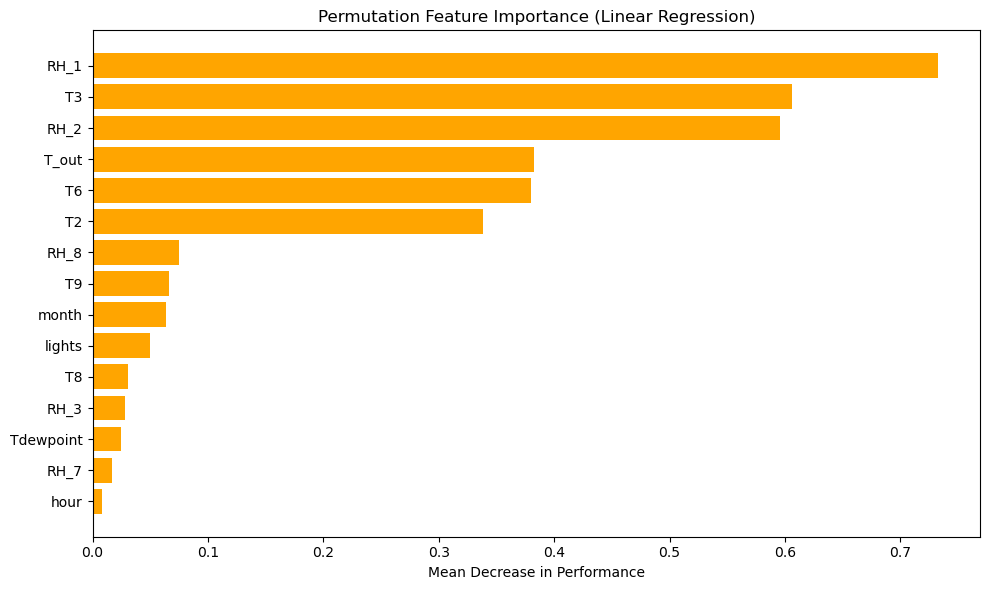

In [10]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

perm_result = permutation_importance(
    lr_model, X_test_scaled, y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

lr_importances = perm_result.importances_mean
indices = np.argsort(lr_importances)[::-1]
feature_names = X.columns[indices]

top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), lr_importances[indices[:top_n]], color='orange')
plt.yticks(range(top_n), feature_names[:top_n])
plt.xlabel("Mean Decrease in Performance")
plt.title("Permutation Feature Importance (Linear Regression)")
plt.gca().invert_yaxis()  # Most important feature at the top
plt.tight_layout()
plt.show()

Then we will check Permutation Feature Importance on Gradient Boosting

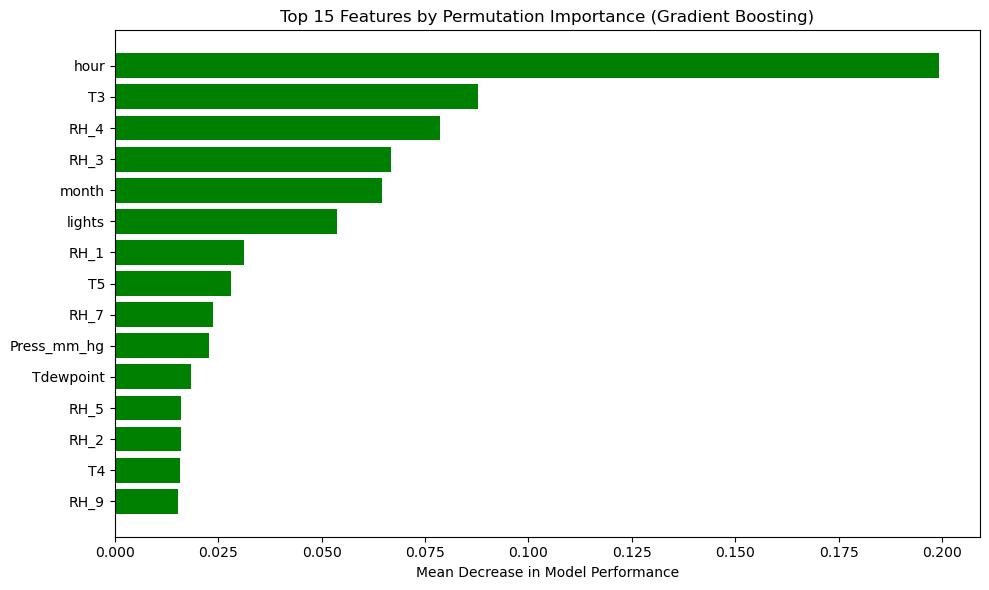

In [11]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

gb_result = permutation_importance(gb_model, X_test_scaled, y_test, n_repeats=5, random_state=42, n_jobs=-1)
gb_importances = gb_result.importances_mean
gb_indices = np.argsort(gb_importances)[::-1]
gb_features = X.columns[gb_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(15), gb_importances[gb_indices][:15], align='center', color='green')
plt.yticks(range(15), gb_features[:15])
plt.xlabel("Mean Decrease in Model Performance")
plt.title("Top 15 Features by Permutation Importance (Gradient Boosting)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Then we will check Permutation Feature Importance on Support vector regressor

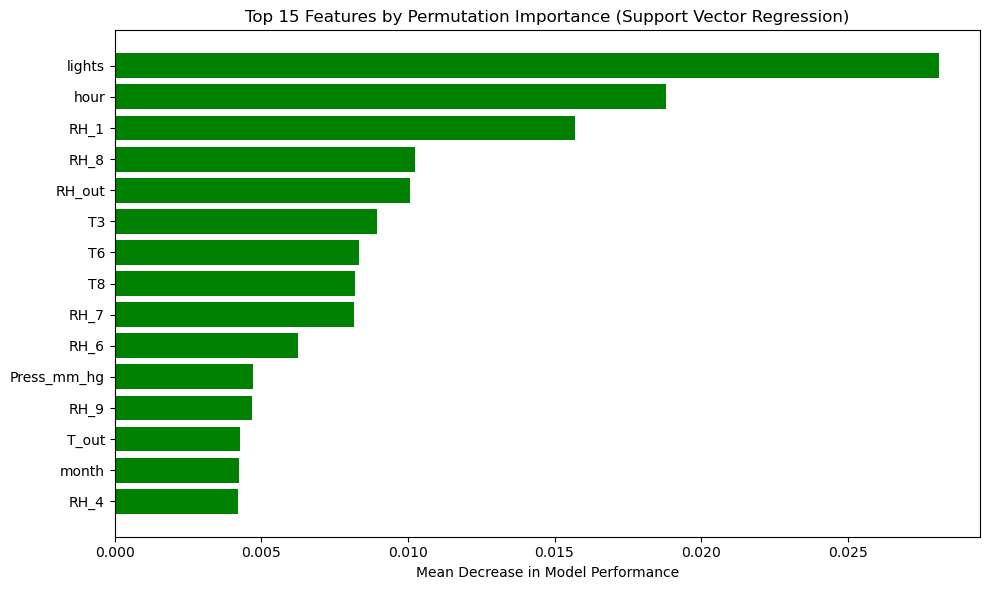

In [12]:
#Support vector regression
from sklearn.svm import SVR
svr_model = SVR(kernel='rbf',gamma='scale')
svr_model.fit(X_train_scaled, y_train)
svr_result = permutation_importance(svr_model, X_test_scaled, y_test, n_repeats=5, random_state=42, n_jobs=-1)
svr_importances = svr_result.importances_mean
svr_indices = np.argsort(svr_importances)[::-1]
svr_features = X.columns[svr_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(15), svr_importances[svr_indices][:15], align='center', color='green')
plt.yticks(range(15), svr_features[:15])
plt.xlabel("Mean Decrease in Model Performance")
plt.title("Top 15 Features by Permutation Importance (Support Vector Regression)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

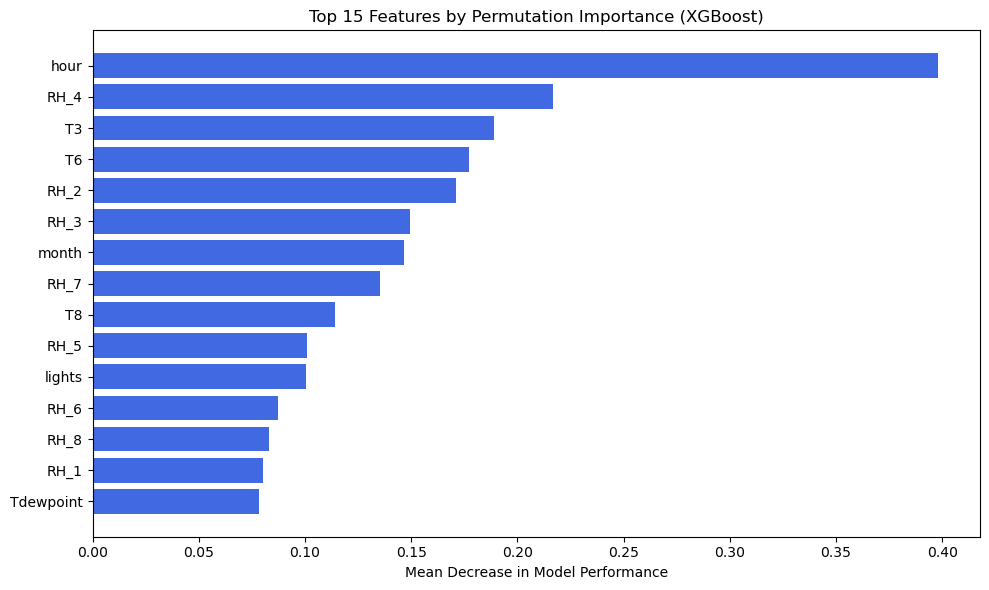

In [63]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(learning_rate=0.1, max_depth=9, n_estimators=300, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train) 

xgb_result = permutation_importance(
    xgb_model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=1
)
xgb_importances = xgb_result.importances_mean
xgb_indices = np.argsort(xgb_importances)[::-1]
xgb_features = X.columns[xgb_indices]

# Plot top 15 features
plt.figure(figsize=(10, 6))
plt.barh(range(15), xgb_importances[xgb_indices][:15], align='center', color='royalblue')
plt.yticks(range(15), xgb_features[:15])
plt.xlabel("Mean Decrease in Model Performance")
plt.title("Top 15 Features by Permutation Importance (XGBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Lastly we will compare the five models against eachother. 

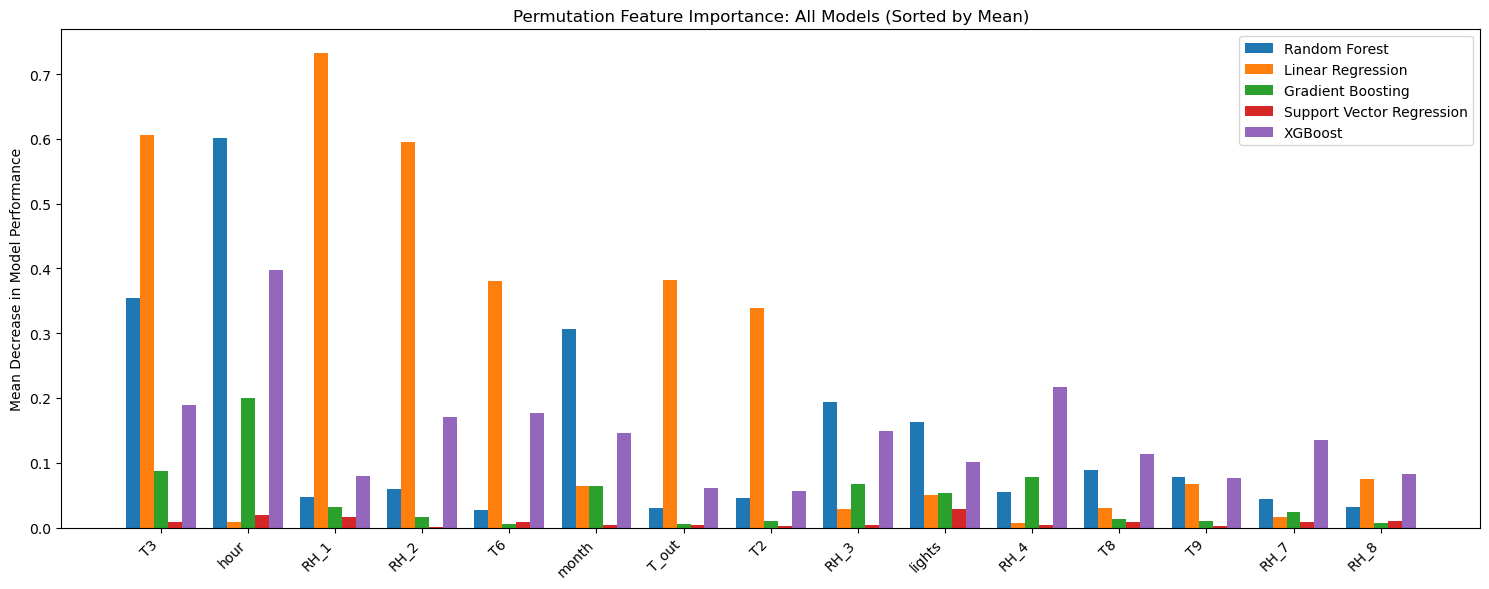

In [64]:
features = X.columns
df_compare = pd.DataFrame({
    'Feature': features,
    'Random Forest': rf_importances,
    'Linear Regression': lr_importances,
    'Gradient Boosting': gb_importances,
    'Support Vector Regression': svr_importances,
    'XGBoost': xgb_importances
}).set_index('Feature')

# Calculate the mean importance across all models (axis=1: row-wise)
df_compare['Mean Importance'] = df_compare.mean(axis=1)

# Sort by mean importance
df_compare_sorted = df_compare.sort_values(by='Mean Importance', ascending=False)
top_features = df_compare_sorted.head(15)
top_feature_names = top_features.index.tolist()

x = np.arange(len(top_features))
bar_width = 0.16  # For five models

plt.figure(figsize=(15, 6))
plt.bar(x - 2*bar_width, top_features['Random Forest'], width=bar_width, label='Random Forest')
plt.bar(x - 1*bar_width, top_features['Linear Regression'], width=bar_width, label='Linear Regression')
plt.bar(x,             top_features['Gradient Boosting'], width=bar_width, label='Gradient Boosting')
plt.bar(x + 1*bar_width, top_features['Support Vector Regression'], width=bar_width, label='Support Vector Regression')
plt.bar(x + 2*bar_width, top_features['XGBoost'], width=bar_width, label='XGBoost')

plt.xticks(x, top_feature_names, rotation=45, ha='right')
plt.ylabel('Mean Decrease in Model Performance')
plt.title('Permutation Feature Importance: All Models (Sorted by Mean)')
plt.legend()
plt.tight_layout()
plt.show()


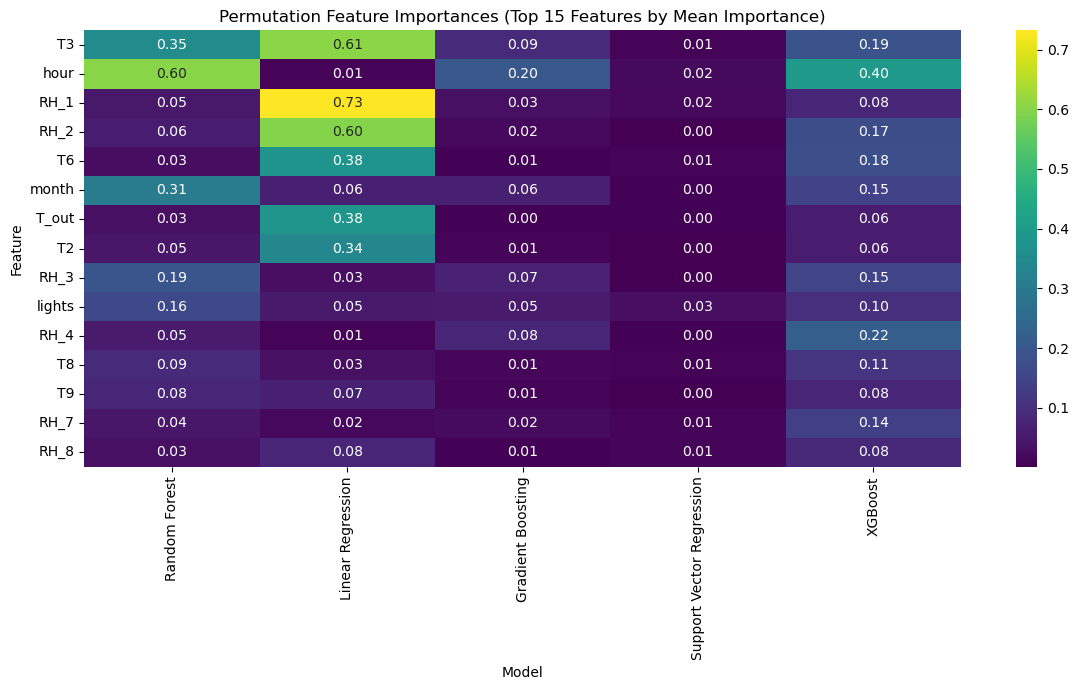

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = df_compare_sorted.iloc[:15, :-1]

plt.figure(figsize=(12, 7))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.2f')
plt.title("Permutation Feature Importances (Top 15 Features by Mean Importance)")
plt.xlabel("Model")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

This shows us that Random Forest and XGBoost are likely the better models of the five, to use on our dataset. 

They consider more features and gives a more balanced feature importance profile. 

To confirm our results we will compare the R² Score of all models

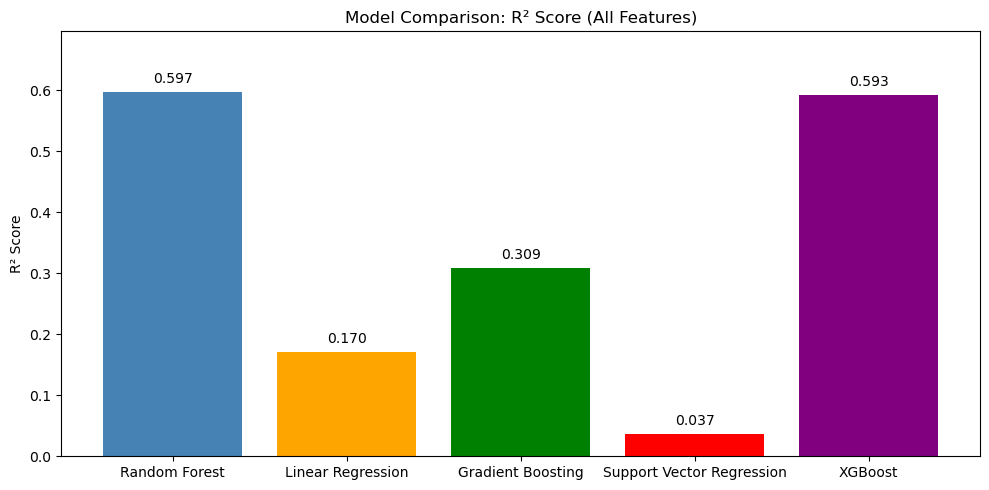

In [66]:
rf_model.fit(X_train_scaled, y_train)
lr_model.fit(X_train_scaled, y_train)
gb_model.fit(X_train_scaled, y_train)
svr_model.fit(X_train_scaled, y_train)
xgb_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_svr = svr_model.predict(X_test_scaled)
y_pred_xgb = xgb_model.predict(X_test_scaled)
r2_rf = r2_score(y_test, y_pred_rf)
r2_lr = r2_score(y_test, y_pred_lr)
r2_gb = r2_score(y_test, y_pred_gb)
r2_svr = r2_score(y_test,y_pred_svr)
r2_xgb = r2_score(y_test, y_pred_xgb)
models = ['Random Forest', 'Linear Regression', 'Gradient Boosting', 'Support Vector Regression', 'XGBoost']
scores = [r2_rf, r2_lr, r2_gb, r2_svr, r2_xgb]

plt.figure(figsize=(10, 5))
bars = plt.bar(models, scores, color=['steelblue', 'orange', 'green', 'red', 'purple'])
plt.ylabel('R² Score')
plt.title('Model Comparison: R² Score (All Features)')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.ylim(0, max(scores) + 0.1)
plt.tight_layout()
plt.show()

The Linear Regression model achieved an R² score of 0.170, indicating a weak performance of only 17% variance

In contrast, the Random Forest model achieved a significantly higher R² score of 0.597, indicating a higher performance with 59% variance
XGBoost is almost at the same as Random Forrest with 59% variance.

Lastly Gradient Boosting has a decent performance of 0.309, indicating 31% of variance, with SVM only having 3% variance

Out of the five models, Random Forrest should be the final choice. It significantly outperforms both Linear Regression, Gradient Boosting and SVM in terms of predictive accuracy. The gap shows that non-linear, tree-based models are better suited to this type of energy usage prediction task.

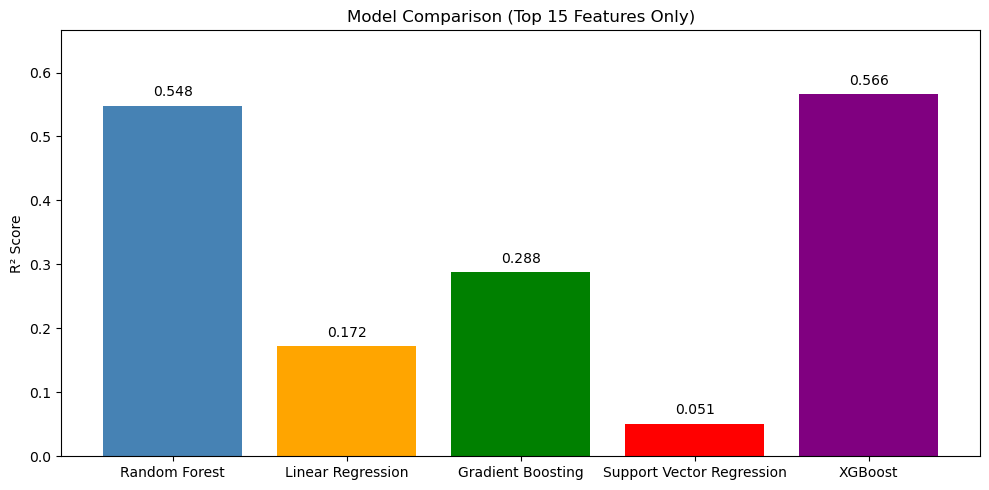

In [71]:
from sklearn.impute import SimpleImputer
X_top = X[top_feature_names].copy()
X_top_train, X_top_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

all_nan_train = X_top_train.columns[X_top_train.isna().all()].tolist()
all_nan_test = X_top_test.columns[X_top_test.isna().all()].tolist()
cols_to_drop = list(set(all_nan_train + all_nan_test))
if cols_to_drop:
    print("Dropping columns with only NaNs after split:", cols_to_drop)
    X_top_train = X_top_train.drop(columns=cols_to_drop)
    X_top_test = X_top_test.drop(columns=cols_to_drop)

if X_top_train.shape[1] == 0:
    raise ValueError("All features have only NaN values after split! Choose another set of top_features.")

imputer = SimpleImputer(strategy="mean")
X_top_train = imputer.fit_transform(X_top_train)
X_top_test = imputer.transform(X_top_test)

scaler_top = StandardScaler()
X_top_train_scaled = scaler_top.fit_transform(X_top_train)
X_top_test_scaled = scaler_top.transform(X_top_test)

rf_top = RandomForestRegressor(n_estimators=50, random_state=42)
lr_top = LinearRegression()
gb_top = GradientBoostingRegressor(n_estimators=100, random_state=42)
svr_top = SVR(kernel='rbf', gamma='scale')
xgb_top = XGBRegressor(learning_rate=0.1, max_depth=9, n_estimators=300, random_state=42, n_jobs=1)

rf_top.fit(X_top_train_scaled, y_train)
lr_top.fit(X_top_train_scaled, y_train)
gb_top.fit(X_top_train_scaled, y_train)
svr_top.fit(X_top_train_scaled, y_train)
xgb_top.fit(X_top_train_scaled, y_train)

y_pred_rf_top = rf_top.predict(X_top_test_scaled)
y_pred_lr_top = lr_top.predict(X_top_test_scaled)
y_pred_gb_top = gb_top.predict(X_top_test_scaled)
y_pred_svr_top = svr_top.predict(X_top_test_scaled)
y_pred_xgb_top = xgb_top.predict(X_top_test_scaled)

r2_rf_top = r2_score(y_test, y_pred_rf_top)
r2_lr_top = r2_score(y_test, y_pred_lr_top)
r2_gb_top = r2_score(y_test, y_pred_gb_top)
r2_svr_top = r2_score(y_test, y_pred_svr_top)
r2_xgb_top = r2_score(y_test, y_pred_xgb_top)

models = ['Random Forest', 'Linear Regression', 'Gradient Boosting', 'Support Vector Regression', 'XGBoost']
scores = [r2_rf_top, r2_lr_top, r2_gb_top, r2_svr_top, r2_xgb_top]

plt.figure(figsize=(10, 5))
bars = plt.bar(models, scores, color=['steelblue', 'orange', 'green', 'red', 'purple'])
plt.ylabel('R² Score')
plt.title('Model Comparison (Top 15 Features Only)')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.ylim(0, max(scores) + 0.1)
plt.tight_layout()
plt.show()

With top 15 features, XGBoost comes out on top. 

SVM again performs the worst.

Gradient Boosting has also slighty decreased in R2 score compared to when it had more features

Lets make a side-by-side comparison to make it even more clear.

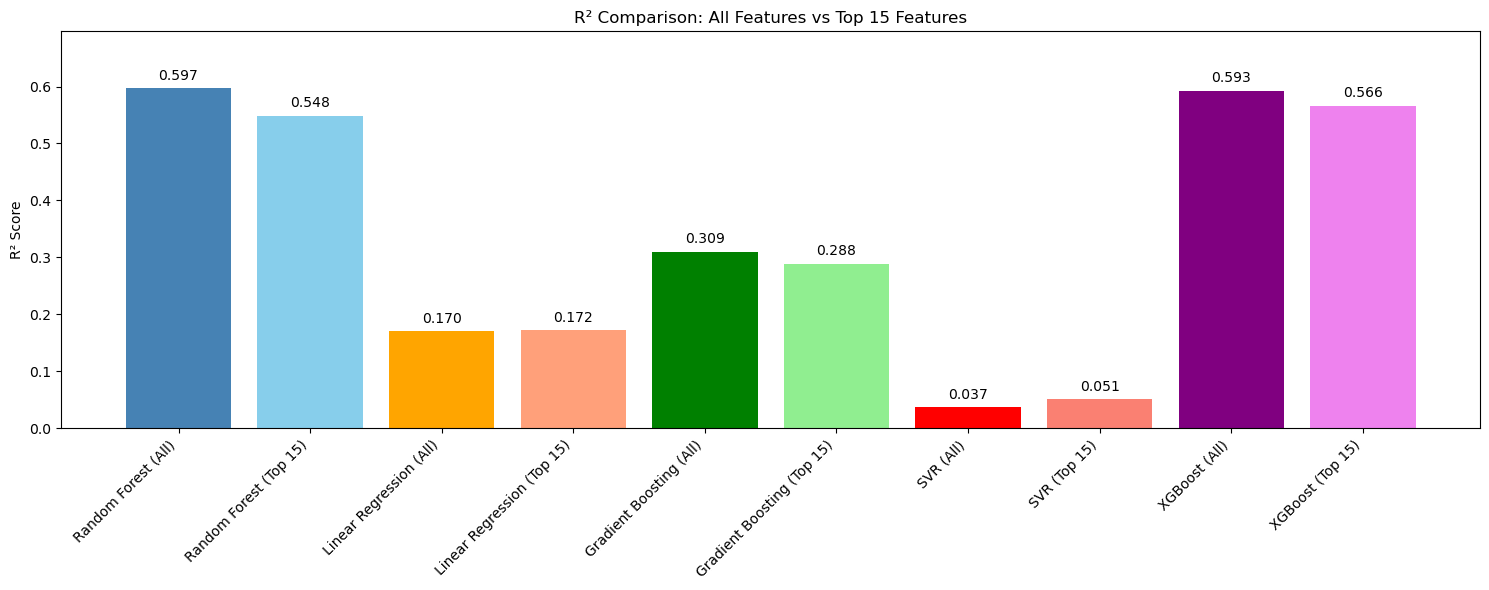

In [69]:
models_extended = [
    'Random Forest (All)', 'Random Forest (Top 15)',
    'Linear Regression (All)', 'Linear Regression (Top 15)',
    'Gradient Boosting (All)', 'Gradient Boosting (Top 15)',
    'SVR (All)', 'SVR (Top 15)',
    'XGBoost (All)', 'XGBoost (Top 15)'
]

scores_combined = [
    r2_rf, r2_rf_top,
    r2_lr, r2_lr_top,
    r2_gb, r2_gb_top,
    r2_svr, r2_svr_top,
    r2_xgb, r2_xgb_top
]

colors_combined = [
    'steelblue', 'skyblue',      # RF
    'orange', 'lightsalmon',     # LR
    'green', 'lightgreen',       # GB
    'red', 'salmon',             # SVR
    'purple', 'violet'           # XGBoost
]

plt.figure(figsize=(15, 6))
bars = plt.bar(models_extended, scores_combined, color=colors_combined)
plt.ylabel('R² Score')
plt.title('R² Comparison: All Features vs Top 15 Features')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.ylim(0, max(scores_combined) + 0.1)
plt.tight_layout()
plt.show()


Now we will train our model on Random Forrest with top 15 features, all features and then compare the two with an R² comparrison and then a risidual analysis.

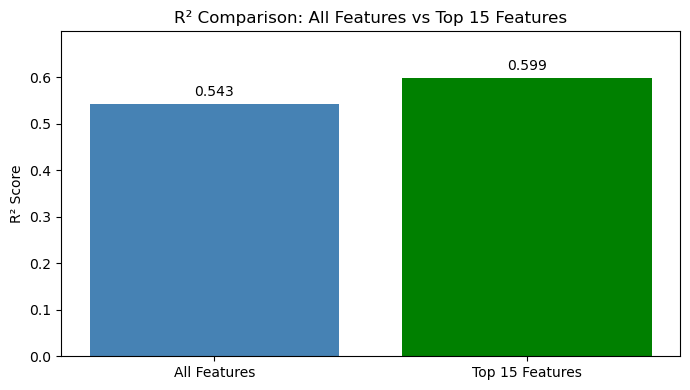

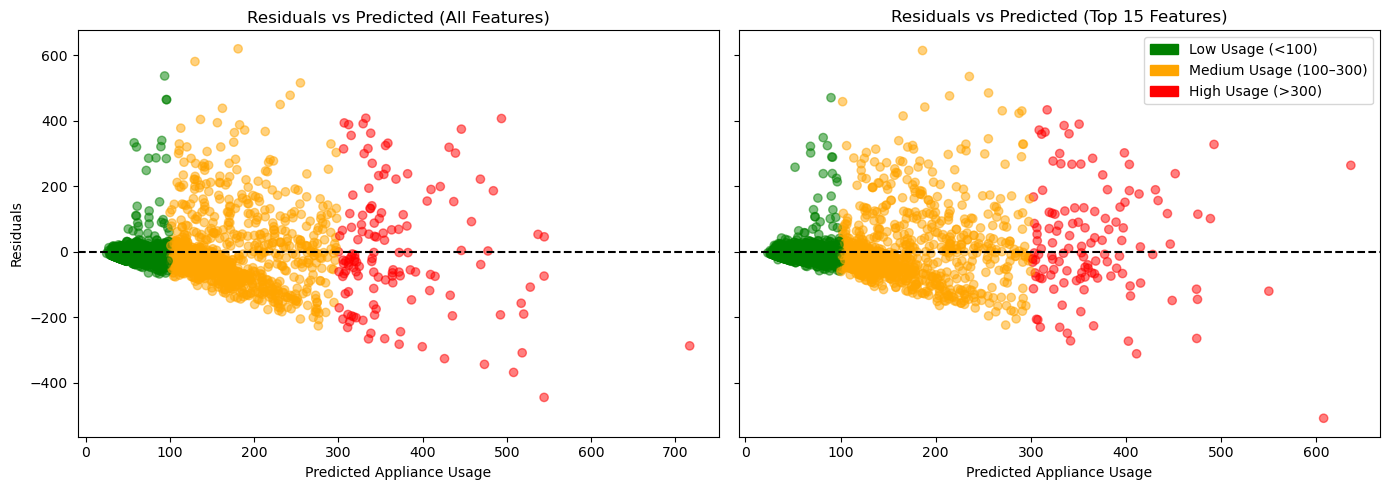

In [17]:
rf_all = RandomForestRegressor(n_estimators=50, random_state=42)
rf_all.fit(X_train_scaled, y_train)
y_pred_all = rf_all.predict(X_test_scaled)
r2_all = r2_score(y_test, y_pred_all)

importances = rf_all.feature_importances_
top_indices = np.argsort(importances)[::-1][:15]
top_features = X.columns[top_indices]

X_top_train = X_train[top_features]
X_top_test = X_test[top_features]

scaler_top = StandardScaler()
X_top_train_scaled = scaler_top.fit_transform(X_top_train)
X_top_test_scaled = scaler_top.transform(X_top_test)

rf_top = RandomForestRegressor(n_estimators=50, random_state=42)
rf_top.fit(X_top_train_scaled, y_train)
y_pred_top = rf_top.predict(X_top_test_scaled)
r2_top = r2_score(y_test, y_pred_top)

models = ['All Features', 'Top 15 Features']
scores = [r2_all, r2_top]

plt.figure(figsize=(7, 4))
bars = plt.bar(models, scores, color=['steelblue', 'green'])
plt.ylabel("R² Score")
plt.title("R² Comparison: All Features vs Top 15 Features")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}", ha='center', va='bottom')

plt.ylim(0, max(scores) + 0.1)
plt.tight_layout()
plt.show()

residuals_all = y_test - y_pred_all
residuals_top = y_test - y_pred_top

colors_all = np.where(y_pred_all < 100, 'green',
              np.where(y_pred_all < 300, 'orange', 'red'))
colors_top = np.where(y_pred_top < 100, 'green',
              np.where(y_pred_top < 300, 'orange', 'red'))

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].scatter(y_pred_all, residuals_all, alpha=0.5, c=colors_all)
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_title("Residuals vs Predicted (All Features)")
axes[0].set_xlabel("Predicted Appliance Usage")
axes[0].set_ylabel("Residuals")

axes[1].scatter(y_pred_top, residuals_top, alpha=0.5, c=colors_top)
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_title("Residuals vs Predicted (Top 15 Features)")
axes[1].set_xlabel("Predicted Appliance Usage")

green_patch = mpatches.Patch(color='green', label='Low Usage (<100)')
orange_patch = mpatches.Patch(color='orange', label='Medium Usage (100–300)')
red_patch = mpatches.Patch(color='red', label='High Usage (>300)')
axes[1].legend(handles=[green_patch, orange_patch, red_patch])

plt.tight_layout()
plt.show()


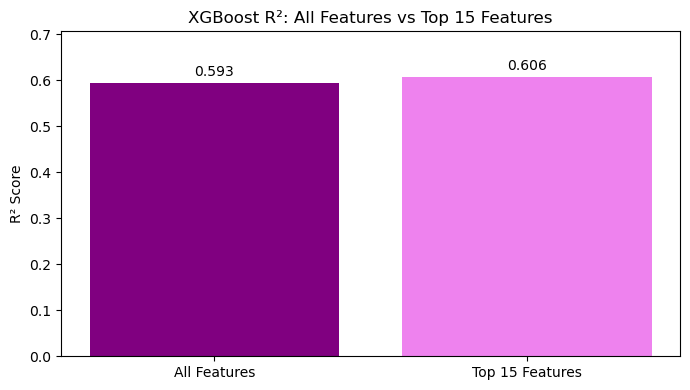

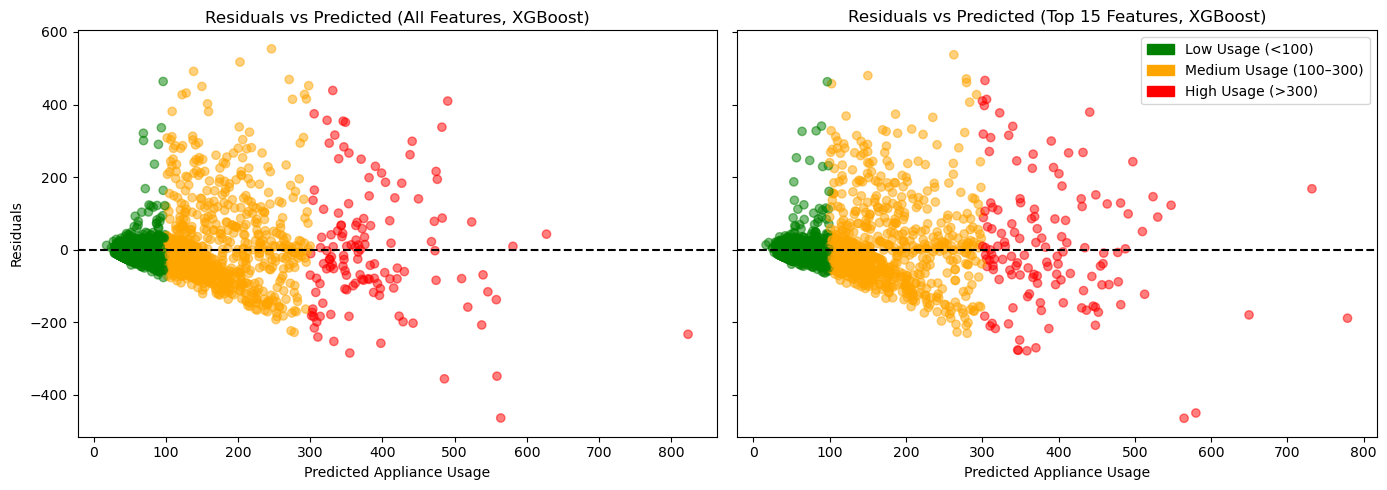

In [70]:
xgb_all = XGBRegressor(learning_rate=0.1, max_depth=9, n_estimators=300, random_state=42, n_jobs=-1)
xgb_all.fit(X_train_scaled, y_train)
y_pred_all = xgb_all.predict(X_test_scaled)
r2_all = r2_score(y_test, y_pred_all)

importances = xgb_all.feature_importances_
top_indices = np.argsort(importances)[::-1][:15]
top_features = X.columns[top_indices]

X_top_train = X_train[top_features]
X_top_test = X_test[top_features]

scaler_top = StandardScaler()
X_top_train_scaled = scaler_top.fit_transform(X_top_train)
X_top_test_scaled = scaler_top.transform(X_top_test)

xgb_top = XGBRegressor(learning_rate=0.1, max_depth=9, n_estimators=300, random_state=42, n_jobs=-1)
xgb_top.fit(X_top_train_scaled, y_train)
y_pred_top = xgb_top.predict(X_top_test_scaled)
r2_top = r2_score(y_test, y_pred_top)

models = ['All Features', 'Top 15 Features']
scores = [r2_all, r2_top]

plt.figure(figsize=(7, 4))
bars = plt.bar(models, scores, color=['purple', 'violet'])
plt.ylabel("R² Score")
plt.title("XGBoost R²: All Features vs Top 15 Features")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}", ha='center', va='bottom')

plt.ylim(0, max(scores) + 0.1)
plt.tight_layout()
plt.show()

residuals_all = y_test - y_pred_all
residuals_top = y_test - y_pred_top

colors_all = np.where(y_pred_all < 100, 'green',
              np.where(y_pred_all < 300, 'orange', 'red'))
colors_top = np.where(y_pred_top < 100, 'green',
              np.where(y_pred_top < 300, 'orange', 'red'))

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].scatter(y_pred_all, residuals_all, alpha=0.5, c=colors_all)
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_title("Residuals vs Predicted (All Features, XGBoost)")
axes[0].set_xlabel("Predicted Appliance Usage")
axes[0].set_ylabel("Residuals")

axes[1].scatter(y_pred_top, residuals_top, alpha=0.5, c=colors_top)
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_title("Residuals vs Predicted (Top 15 Features, XGBoost)")
axes[1].set_xlabel("Predicted Appliance Usage")

green_patch = mpatches.Patch(color='green', label='Low Usage (<100)')
orange_patch = mpatches.Patch(color='orange', label='Medium Usage (100–300)')
red_patch = mpatches.Patch(color='red', label='High Usage (>300)')
axes[1].legend(handles=[green_patch, orange_patch, red_patch])

plt.tight_layout()
plt.show()

As we can see our top 15 feature model not only performs better on R² score, but has more consistent residuals especially in high-usage zones — which is crucial for a real-world energy forecasting models.
Since the both model seems to perform well, let's now try to optimize the hyperparameters. 
First, we have seen that optimizing the number of features not only optimize the computatiional time, but also the accuracy of our regressor. Let's choose the best number of features.


In [72]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
r2_rf = r2_score(y_test, y_pred_rf)
y_train_pred_rf = rf_model.predict(X_train_scaled)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
print(f"Random Forest R² Score (Test): {r2_rf:.3f}")
print(f"Random Forest R² Score (Train): {r2_train_rf:.3f}")

# XGBoost
xgb_model = XGBRegressor(learning_rate=0.1, max_depth=9, n_estimators=300, random_state=42, n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
r2_xgb = r2_score(y_test, y_pred_xgb)
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
print(f"XGBoost R² Score (Test): {r2_xgb:.3f}")
print(f"XGBoost R² Score (Train): {r2_train_xgb:.3f}")

Random Forest R² Score (Test): 0.543
Random Forest R² Score (Train): 0.931
XGBoost R² Score (Test): 0.593
XGBoost R² Score (Train): 0.978


We first notice that not only we can optimise hyperparameters to enhance our models, but also that this is actually really important since we are in a hard case of overfitting. Using GridSearchCV and therefore cross validation to opitmize will be really useful here.

In [73]:
# Random Forest feature ranking
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_importances = rf_model.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]

print("Random Forest Feature Ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[rf_indices[f]]} ({rf_importances[rf_indices[f]]:.5f})")

print("\n" + "-"*50 + "\n")

# XGBoost feature ranking
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=9, random_state=42, n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train)
xgb_importances = xgb_model.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1]

print("XGBoost Feature Ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[xgb_indices[f]]} ({xgb_importances[xgb_indices[f]]:.5f})")


Random Forest Feature Ranking:
1. feature hour (0.15128)
2. feature T3 (0.05833)
3. feature RH_3 (0.04338)
4. feature RH_5 (0.03931)
5. feature Press_mm_hg (0.03726)
6. feature T8 (0.03642)
7. feature RH_2 (0.03482)
8. feature RH_1 (0.03173)
9. feature Tdewpoint (0.03156)
10. feature T2 (0.02941)
11. feature T4 (0.02928)
12. feature RH_out (0.02919)
13. feature RH_8 (0.02906)
14. feature RH_7 (0.02906)
15. feature RH_9 (0.02888)
16. feature RH_4 (0.02870)
17. feature lights (0.02851)
18. feature RH_6 (0.02718)
19. feature T7 (0.02700)
20. feature T6 (0.02638)
21. feature T_out (0.02547)
22. feature Windspeed (0.02536)
23. feature T1 (0.02348)
24. feature T5 (0.02280)
25. feature month (0.02163)
26. feature Visibility (0.02136)
27. feature rv2 (0.01940)
28. feature rv1 (0.01923)
29. feature T9 (0.01888)
30. feature day (0.01810)
31. feature weekday (0.00756)

--------------------------------------------------

XGBoost Feature Ranking:
1. feature month (0.32623)
2. feature hour (0.13811)

step 1 done
step 2 done
step 3 done
step 4 done
step 5 done
step 6 done
step 7 done
step 8 done
step 9 done
step 10 done
step 11 done
step 12 done
step 13 done
step 14 done
step 15 done
step 16 done
step 17 done
step 18 done
step 19 done
step 20 done
step 21 done
step 22 done
step 23 done
step 24 done
step 25 done
step 26 done
step 27 done
step 28 done
step 29 done
step 30 done
step 31 done


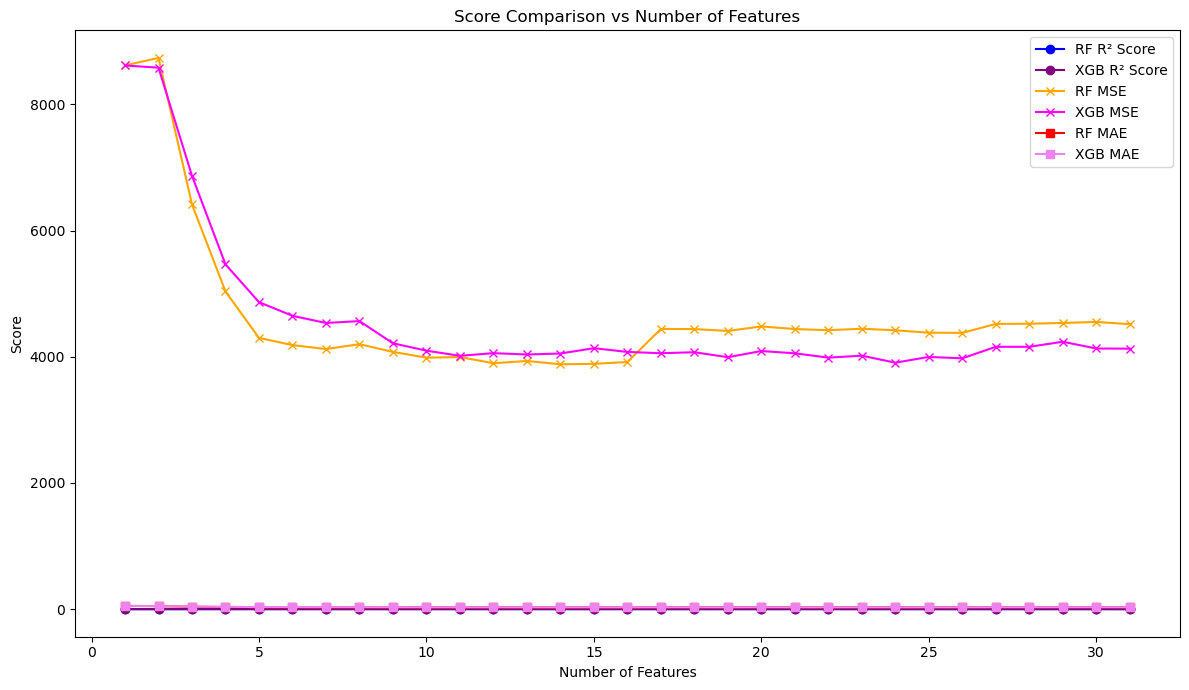

In [74]:
# For Random Forest
r2_scores_rf = []
MSE_scores_rf = []
MAE_scores_rf = []

# For XGBoost
r2_scores_xgb = []
MSE_scores_xgb = []
MAE_scores_xgb = []

for i in range(1, X.shape[1] + 1):
    top_features = indices[:i]
    X_train_top = X_train_scaled[:, top_features]
    X_test_top = X_test_scaled[:, top_features]

    # Random Forest
    rf_model.fit(X_train_top, y_train)
    y_pred_rf = rf_model.predict(X_test_top)
    r2_scores_rf.append(r2_score(y_test, y_pred_rf))
    MSE_scores_rf.append(np.mean((y_test - y_pred_rf) ** 2))
    MAE_scores_rf.append(np.mean(np.abs(y_test - y_pred_rf)))

    # XGBoost
    xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=9, random_state=42, n_jobs=-1)
    xgb_model.fit(X_train_top, y_train)
    y_pred_xgb = xgb_model.predict(X_test_top)
    r2_scores_xgb.append(r2_score(y_test, y_pred_xgb))
    MSE_scores_xgb.append(np.mean((y_test - y_pred_xgb) ** 2))
    MAE_scores_xgb.append(np.mean(np.abs(y_test - y_pred_xgb)))

    print(f"step {i} done")

# Plot R², MSE, and MAE scores for both models
plt.figure(figsize=(12, 7))
plt.plot(range(1, X.shape[1] + 1), r2_scores_rf, marker='o', color='blue', label='RF R² Score')
plt.plot(range(1, X.shape[1] + 1), r2_scores_xgb, marker='o', color='purple', label='XGB R² Score')
plt.plot(range(1, X.shape[1] + 1), MSE_scores_rf, marker='x', color='orange', label='RF MSE')
plt.plot(range(1, X.shape[1] + 1), MSE_scores_xgb, marker='x', color='magenta', label='XGB MSE')
plt.plot(range(1, X.shape[1] + 1), MAE_scores_rf, marker='s', color='red', label='RF MAE')
plt.plot(range(1, X.shape[1] + 1), MAE_scores_xgb, marker='s', color='violet', label='XGB MAE')
plt.legend()
plt.title("Score Comparison vs Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

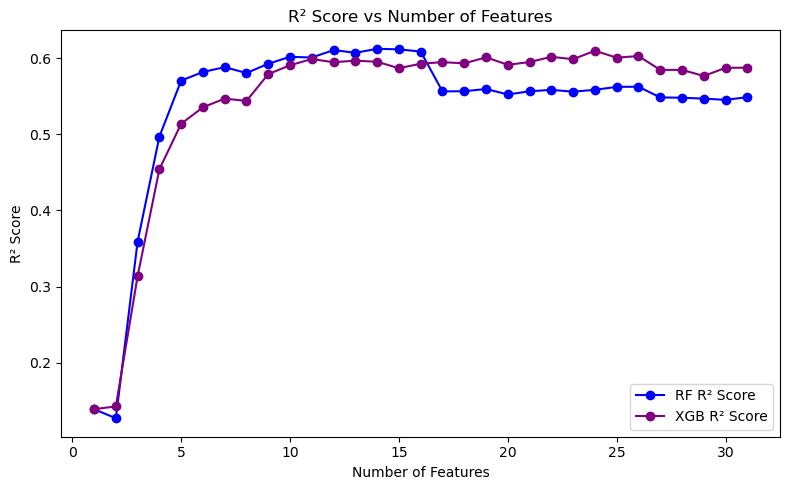

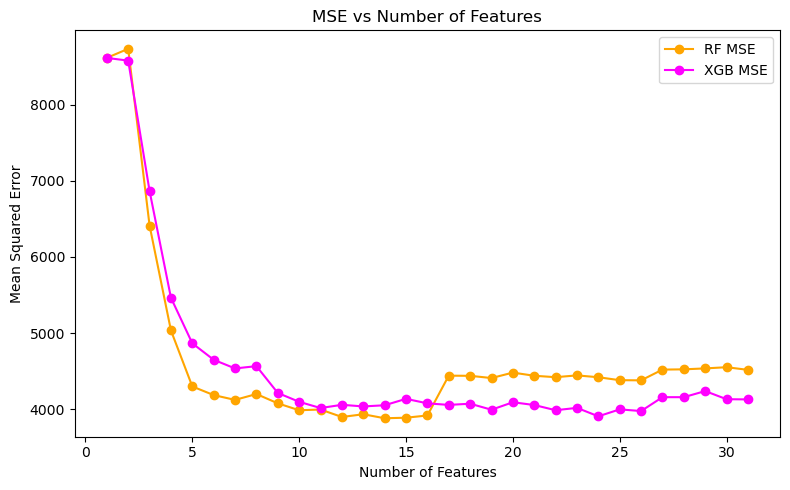

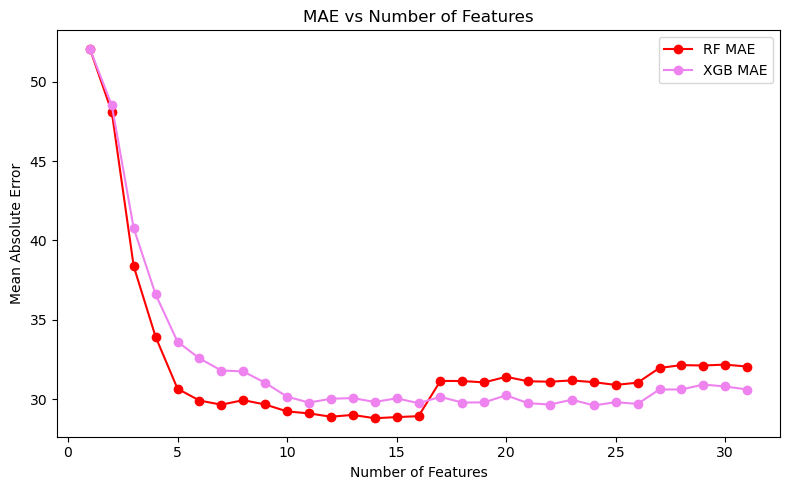

In [76]:
plt.figure(figsize=(8,5))
plt.plot(range(1, X.shape[1] + 1), r2_scores_rf, marker='o', color='blue', label='RF R² Score')
plt.plot(range(1, X.shape[1] + 1), r2_scores_xgb, marker='o', color='purple', label='XGB R² Score')
plt.xlabel("Number of Features")
plt.ylabel("R² Score")
plt.title("R² Score vs Number of Features")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, X.shape[1] + 1), MSE_scores_rf, marker='o', color='orange', label='RF MSE')
plt.plot(range(1, X.shape[1] + 1), MSE_scores_xgb, marker='o', color='magenta', label='XGB MSE')
plt.xlabel("Number of Features")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs Number of Features")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, X.shape[1] + 1), MAE_scores_rf, marker='o', color='red', label='RF MAE')
plt.plot(range(1, X.shape[1] + 1), MAE_scores_xgb, marker='o', color='violet', label='XGB MAE')
plt.xlabel("Number of Features")
plt.ylabel("Mean Absolute Error")
plt.title("MAE vs Number of Features")
plt.legend()
plt.tight_layout()
plt.show()

15 features in fact minimizes both the MSE and the MAE while maximising the R^2 score : we found or top numbers of features. Let's, from now on keep only 15 features and optimize the hyperparameters. We will use grid search, and the scoring will be R^2 scores. First let's optimize n_estimators.

In [78]:
#Optimizing n_estimators in random forest with grid search
from sklearn.model_selection import GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 150, 200]

}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled[:,indices[:15]], y_train)
best_n_estimators_rf = grid_search.best_params_['n_estimators']
print(f"Best n_estimators: {best_n_estimators_rf}")

param_grid_xgb = {
    'n_estimators': [50, 100, 150, 200]
}

xgb_model = XGBRegressor(learning_rate=0.1, max_depth=9, random_state=42, n_jobs=-1)

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search_xgb.fit(X_train_scaled[:, indices[:15]], y_train)
best_n_estimators_xgb = grid_search_xgb.best_params_['n_estimators']
print(f"Best n_estimators for XGBoost: {best_n_estimators_xgb}")


Best n_estimators: 200
Best n_estimators for XGBoost: 200


Now max_depth.

In [80]:
#optimizing max_depth in random forest with grid search
rf_model = RandomForestRegressor(n_estimators=best_n_estimators_rf, random_state=42)
param_grid_rf = {
    'max_depth': [5, 10, 15, 20, None]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled[:,indices[:15]], y_train)
best_max_depth_rf = grid_search.best_params_['max_depth']
print(f"Best max_depth: {best_max_depth_rf}")

xgb_model = XGBRegressor(
    n_estimators=best_n_estimators_xgb,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

param_grid_xgb = {
    'max_depth': [5, 10, 15, 20]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search_xgb.fit(X_train_scaled[:, indices[:15]], y_train)
best_max_depth_xgb = grid_search_xgb.best_params_['max_depth']
print(f"Best max_depth for XGBoost: {best_max_depth_xgb}")

Best max_depth: None
Best max_depth for XGBoost: 10


Now min_samples_split

In [81]:
#optimizing min_samples_split in random forest with grid search
rf_model = RandomForestRegressor(n_estimators=best_n_estimators_rf, max_depth=best_max_depth_rf, random_state=42)
param_grid_rf = {
    'min_samples_split': [2, 5, 10, 20]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled[:,indices[:15]], y_train)
best_min_samples_split_rf = grid_search.best_params_['min_samples_split']
print(f"Best min_samples_split: {best_min_samples_split_rf}")

xgb_model = XGBRegressor(
    n_estimators=best_n_estimators_xgb,  
    max_depth=best_max_depth_xgb,       
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

param_grid_xgb = {
    'min_child_weight': [1, 5, 10, 20] 
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search_xgb.fit(X_train_scaled[:, indices[:15]], y_train)
best_min_child_weight_xgb = grid_search_xgb.best_params_['min_child_weight']
print(f"Best min_child_weight for XGBoost: {best_min_child_weight_xgb}")

Best min_samples_split: 2
Best min_child_weight for XGBoost: 1


Now min_samples_leaf.

In [82]:
#optimizing min_samples_leaf in random forest with grid search
rf_model = RandomForestRegressor(n_estimators=best_n_estimators_rf, max_depth=best_max_depth_rf, min_samples_split=best_min_samples_split_rf, random_state=42)
param_grid_rf = {
    'min_samples_leaf': [1, 2, 4, 10]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled[:,indices[:15]], y_train)
best_min_samples_leaf_rf = grid_search.best_params_['min_samples_leaf']
print(f"Best min_samples_leaf: {best_min_samples_leaf_rf}")

xgb_model = XGBRegressor(
    n_estimators=best_n_estimators_xgb,     
    max_depth=best_max_depth_xgb,           
    min_child_weight=best_min_child_weight_xgb,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)


param_grid_xgb = {
    'min_child_weight': [1, 2, 4, 10]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search_xgb.fit(X_train_scaled[:, indices[:15]], y_train)
best_min_child_weight_xgb = grid_search_xgb.best_params_['min_child_weight']
print(f"Best min_child_weight for XGBoost: {best_min_child_weight_xgb}")


Best min_samples_leaf: 1
Best min_child_weight for XGBoost: 2


Now max_features.

In [83]:
#optimizing max_features in random forest with grid search
rf_model = RandomForestRegressor(n_estimators=best_n_estimators_rf, max_depth=best_max_depth_rf, min_samples_split=best_min_samples_split_rf, min_samples_leaf=best_min_samples_leaf_rf, random_state=42)
param_grid_rf = {
    'max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled[:,indices[:15]], y_train)
best_max_features_rf = grid_search.best_params_['max_features']
print(f"Best max_features: {best_max_features_rf}")

xgb_model = XGBRegressor(
    n_estimators=best_n_estimators_xgb,      
    max_depth=best_max_depth_xgb,
    min_child_weight=best_min_child_weight_xgb,  
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

param_grid_xgb = {
    'colsample_bytree': [0.5, 0.7, 1.0]  
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search_xgb.fit(X_train_scaled[:, indices[:15]], y_train)
best_colsample_bytree_xgb = grid_search_xgb.best_params_['colsample_bytree']
print(f"Best colsample_bytree for XGBoost: {best_colsample_bytree_xgb}")

Best max_features: sqrt
Best colsample_bytree for XGBoost: 0.5


Now that we have the best parameters, let's train the best model and compare the metrics with our unoptimized model.

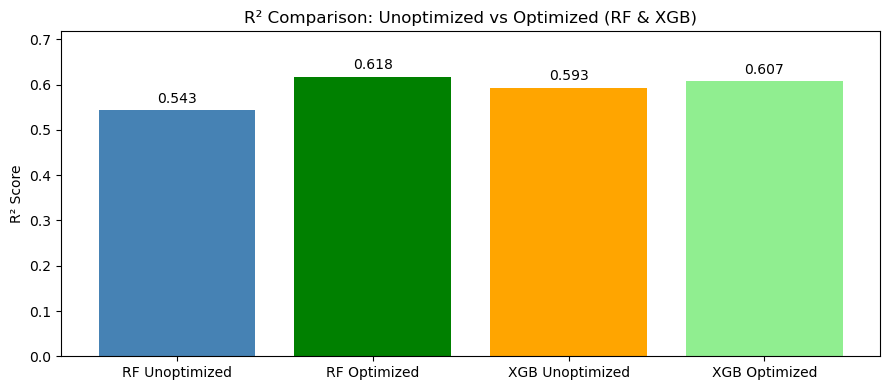

In [85]:
rf_model = RandomForestRegressor(
    n_estimators=best_n_estimators_rf,
    max_depth=best_max_depth_rf,
    min_samples_split=best_min_samples_split_rf,
    min_samples_leaf=best_min_samples_leaf_rf,
    max_features=best_max_features_rf,
    random_state=42
)

rf_model.fit(X_train_scaled[:, indices[:15]], y_train)
y_pred_rf_final = rf_model.predict(X_test_scaled[:, indices[:15]])
r2_rf_final = r2_score(y_test, y_pred_rf_final)

xgb_model = XGBRegressor(
    n_estimators=best_n_estimators_xgb,
    max_depth=best_max_depth_xgb,
    min_child_weight=best_min_child_weight_xgb,
    colsample_bytree=best_colsample_bytree_xgb,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_scaled[:, indices[:15]], y_train)
y_pred_xgb_final = xgb_model.predict(X_test_scaled[:, indices[:15]])
r2_xgb_final = r2_score(y_test, y_pred_xgb_final)

models = [
    'RF Unoptimized', 'RF Optimized',
    'XGB Unoptimized', 'XGB Optimized'
]
scores = [
    r2_rf, r2_rf_final,
    r2_xgb, r2_xgb_final
]

plt.figure(figsize=(9, 4))
bars = plt.bar(models, scores, color=['steelblue', 'green', 'orange', 'lightgreen'])
plt.ylabel("R² Score")
plt.title("R² Comparison: Unoptimized vs Optimized (RF & XGB)")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f"{yval:.3f}", ha='center', va='bottom')

plt.ylim(0, max(scores) + 0.1)
plt.tight_layout()
plt.show()


Let's now try to have a visualization of whether our regression is good. We plot the real appliance of the house on a day (meaned hour by hour) and our predictions.

hour
0      72.000000
1      73.000000
2      51.000000
3      47.000000
4      52.333333
5      47.000000
6      50.000000
7      59.666667
8      61.666667
9      69.333333
10    100.666667
11    105.000000
12    158.000000
13    147.666667
14    139.333333
15     67.666667
16     88.666667
17    214.333333
18    179.333333
19    163.666667
20    159.333333
21    100.666667
22     65.666667
23     54.000000
Name: Appliances, dtype: float64


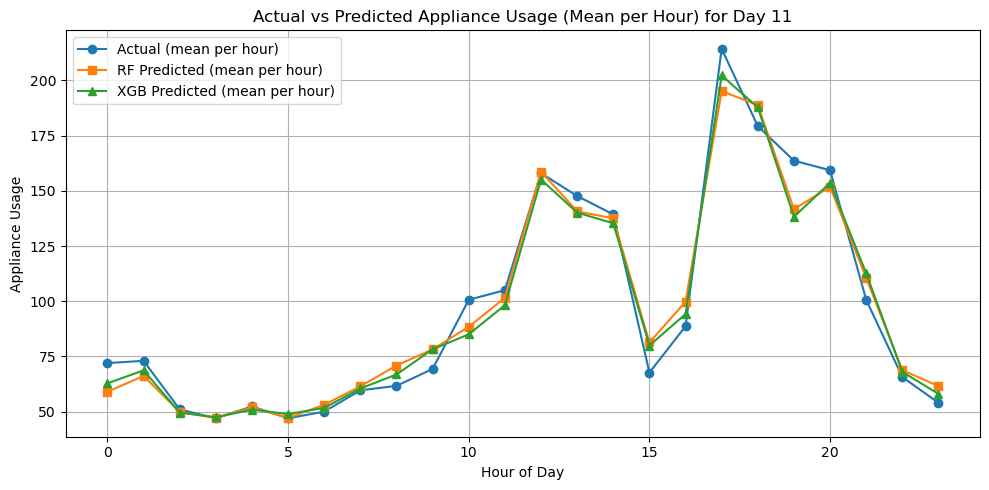

In [88]:
df_day11 = df[df['day'] == 12].groupby('hour')['Appliances'].mean()
print(df_day11)

X_day11 = df[df['day'] == 12][X_train.columns]
X_day11_scaled = scaler.transform(X_day11)

# Random Forest prediction
y_day11_pred_rf = rf_model.predict(X_day11_scaled[:, indices[:15]])

# XGBoost prediction
y_day11_pred_xgb = xgb_model.predict(X_day11_scaled[:, indices[:15]])

# Mean prediction for each hour
hours = df[df['day'] == 12]['hour'].values
unique_hours = np.unique(hours)
y_day11_pred_mean_rf = [y_day11_pred_rf[hours == h].mean() for h in unique_hours]
y_day11_pred_mean_xgb = [y_day11_pred_xgb[hours == h].mean() for h in unique_hours]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_day11.index, df_day11.values, marker='o', label='Actual (mean per hour)')
plt.plot(unique_hours, y_day11_pred_mean_rf, marker='s', label='RF Predicted (mean per hour)')
plt.plot(unique_hours, y_day11_pred_mean_xgb, marker='^', label='XGB Predicted (mean per hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Appliance Usage')
plt.title('Actual vs Predicted Appliance Usage (Mean per Hour) for Day 11')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


We are quite happy about these results :) Not only this shows that our model is well trained, but only that it generalizes well (since here it's no more question of train/test sets). We actually treated the problem of overfitting and enhanced the model. However, we still have a quite big MSE. Therefore, let's try another point of view. The mean instantanante appliance here is 60. Let's transform our problem in a classification problem.

In [31]:
#New target when appliance is above 60 = 1, else 0
df['Target'] = (df['Appliances'] > 60).astype(int)
df_new=df.drop(columns=['Appliances'])
# Separate features and new target variable
X_new = df.drop(columns=['Appliances', 'Target'])
y_new = df['Target']
scale= StandardScaler()
X_new_scaled = scale.fit_transform(X_new)
# Train-test split for new target
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new_scaled, y_new, test_size=0.2, random_state=42)
print(y_new)


0        0
1        0
2        0
3        0
4        0
        ..
19730    1
19731    1
19732    1
19733    1
19734    1
Name: Target, Length: 19735, dtype: int32


Let's begin with a pair plot of some of our features

<Figure size 1200x1000 with 0 Axes>

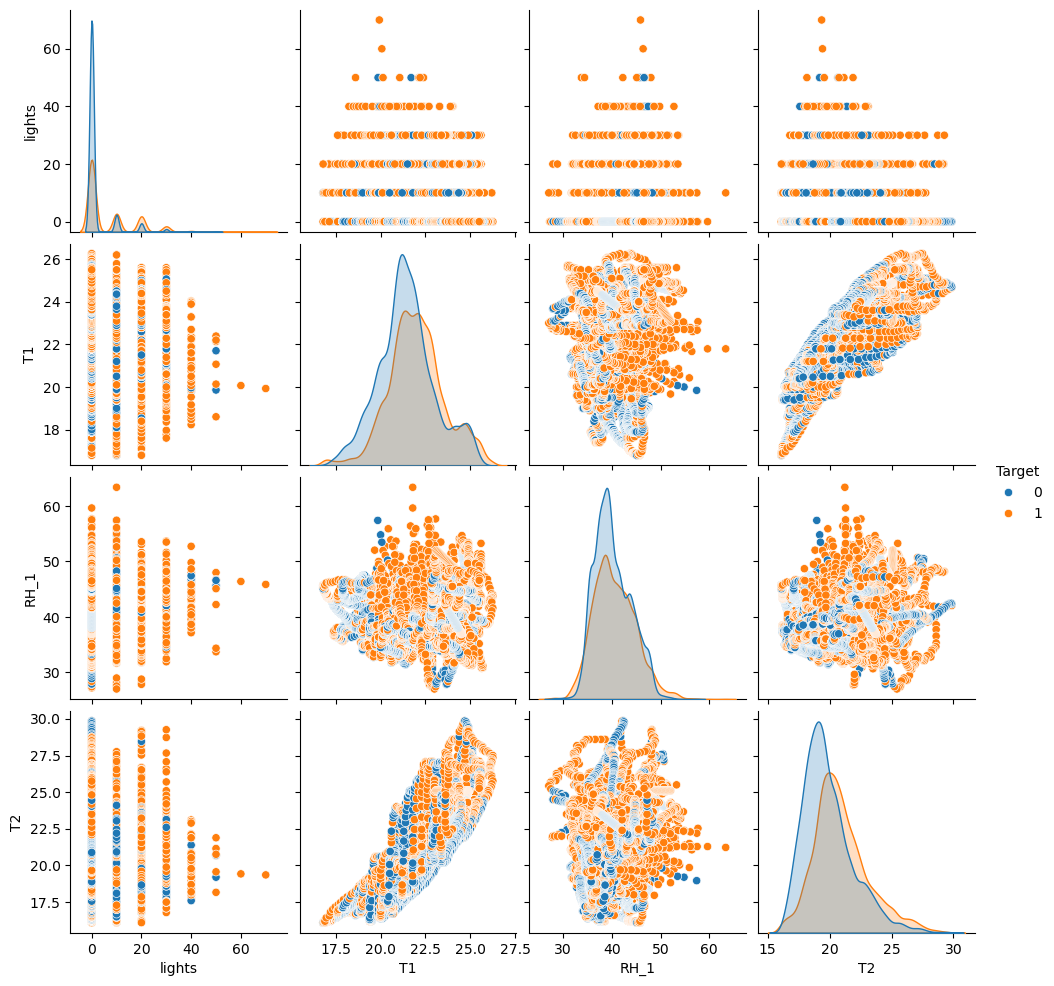

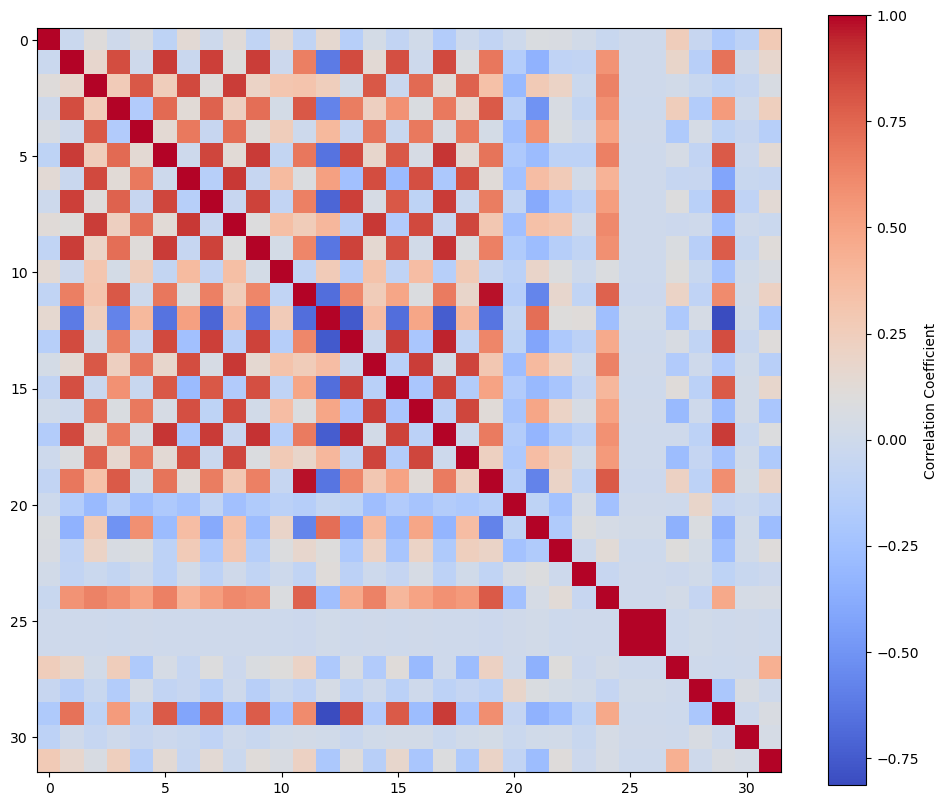

In [34]:
#pair plot of the features and correlation matrix
import seaborn as sns
#pairplot only the 4 features 'lights', 'T1', 'RH_1', 'T_2' and the new target
plt.figure(figsize=(12, 10))
sns.pairplot(df_new[['lights', 'T1', 'RH_1', 'T2', 'Target']], hue='Target')
plt.figure(figsize=(12, 10))
correlation_matrix_new = df_new.corr()
plt.imshow(correlation_matrix_new, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.show()


We can't see any linear relationhips from this pairplot. We will try 4 classification models : Random Forest, SVM, KNN, and a neural network. This observations leads us to think that the tuning of hyperparameters will be mandatory.

Accuracy: 0.898
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      2127
           1       0.89      0.88      0.89      1820

    accuracy                           0.90      3947
   macro avg       0.90      0.90      0.90      3947
weighted avg       0.90      0.90      0.90      3947



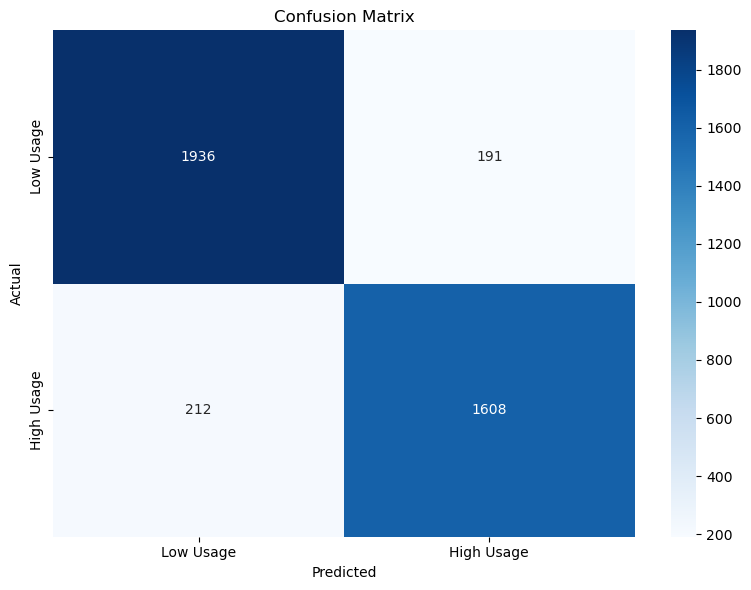

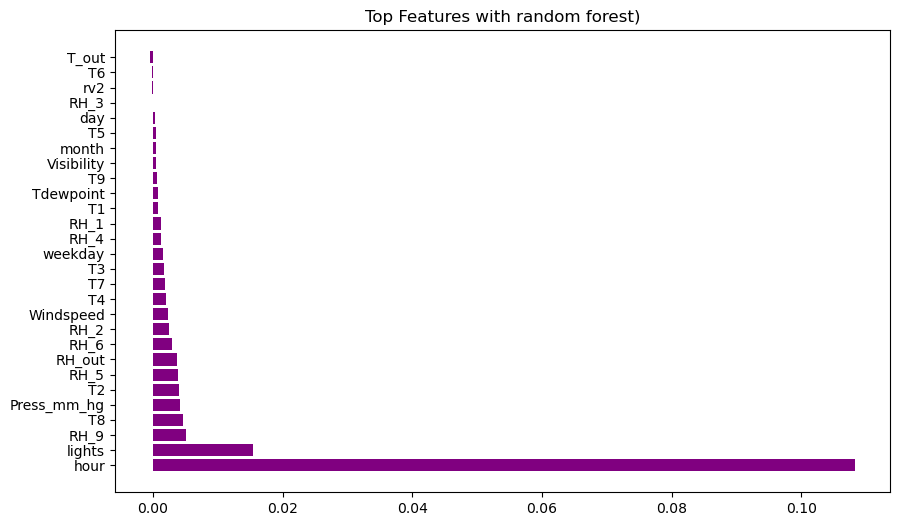

In [35]:
#Train a naive random forest 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
rf_model_new = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model_new.fit(X_new_train, y_new_train)
y_pred_new = rf_model_new.predict(X_new_test)
# Calculate accuracy and classification report
accuracy = accuracy_score(y_new_test, y_pred_new)
print(f"Accuracy: {accuracy:.3f}")
print("Classification Report:")
print(classification_report(y_new_test, y_pred_new))
# Plot confusion matrix
cm = confusion_matrix(y_new_test, y_pred_new)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Usage', 'High Usage'], yticklabels=['Low Usage', 'High Usage'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
# Feature importance for the new target

result_new = permutation_importance(rf_model_new, X_new_test, y_new_test, n_repeats=5, random_state=42, n_jobs=-1)
rf_importances_new = result_new.importances_mean
indices_new = np.argsort(rf_importances_new)[::-1]
features_new = X_new.columns[indices_new]
plt.figure(figsize=(10, 6))
plt.barh(range(28), rf_importances_new[indices_new][:28], align='center', color='purple')
plt.yticks(range(28), features_new[:28])

plt.title("Top Features with random forest)")
plt.show()





It seems that for this classification task, some features are way more discriminative that others. Let's check that by plotting the accuracy function of the number of features.

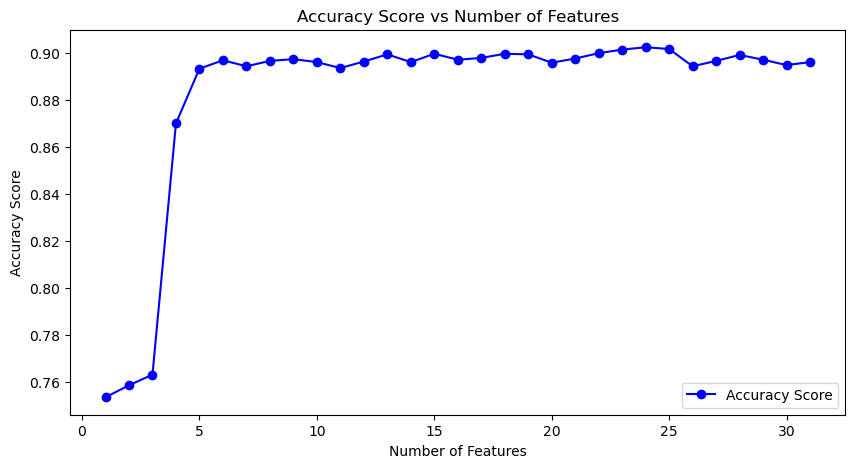

In [36]:
#Plotting accuracy vs number of features
accuracy_scores = []
for i in range(1, X_new.shape[1] + 1):
    top_features_new = indices_new[:i]
    X_new_train_top = X_new_train[:, top_features_new]
    X_new_test_top = X_new_test[:, top_features_new]

    rf_model_new.fit(X_new_train_top, y_new_train)
    y_pred_new = rf_model_new.predict(X_new_test_top)
    accuracy_scores.append(accuracy_score(y_new_test, y_pred_new))
# Plot accuracy scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, X_new.shape[1] + 1), accuracy_scores, marker='o', color='blue', label='Accuracy Score')
plt.legend()
plt.title("Accuracy Score vs Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy Score")
plt.show()

In [38]:
#Considering only the top 6 features.
top_features_new = indices_new[:6]
X_new_train_top = X_new_train[:, top_features_new]
X_new_test_top = X_new_test[:, top_features_new]


From this plot we see that after 6 features the accuracy does not increase significantly, so we can use the top 6 features for our model.

In [39]:
#Optimzing with grid search the random forest classifier, first with n_estimators
from sklearn.model_selection import GridSearchCV
rf= RandomForestClassifier(random_state=42)
param_grid_new_estimators = {
    'n_estimators': [50, 100, 150, 200]
}
grid_search_new = GridSearchCV(estimator=rf, param_grid=param_grid_new_estimators, cv=3, scoring='accuracy', n_jobs=-1,verbose=2)
grid_search_new.fit(X_new_train_top, y_new_train)
best_params_new = grid_search_new.best_params_
print(f"Best parameters for Random Forest Classifier: {best_params_new}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters for Random Forest Classifier: {'n_estimators': 200}


In [40]:
#Now optimizing max_depth
param_grid_new_depth = {
    'max_depth': [5, 10, 15, 20, None]
}
grid_search_new_depth = GridSearchCV(estimator=RandomForestClassifier(n_estimators=200,random_state=42), param_grid=param_grid_new_depth, cv=3, scoring='accuracy', n_jobs=-1,verbose=2)
grid_search_new_depth.fit(X_new_train_top, y_new_train)
best_params_new_depth = grid_search_new_depth.best_params_
print(f"Best max_depth for Random Forest Classifier: {best_params_new_depth['max_depth']}")


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best max_depth for Random Forest Classifier: None


In [41]:
#Now optimizing min_samples_split
param_grid_new_split = {
    'min_samples_split': [2, 5, 10, 20]
}
grid_search_new_split = GridSearchCV(estimator=RandomForestClassifier(n_estimators=200, max_depth=best_params_new_depth['max_depth'], random_state=42), param_grid=param_grid_new_split, cv=3, scoring='accuracy', n_jobs=-1,verbose=2)
grid_search_new_split.fit(X_new_train_top, y_new_train)
best_params_new_split = grid_search_new_split.best_params_
print(f"Best min_samples_split for Random Forest Classifier: {best_params_new_split['min_samples_split']}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best min_samples_split for Random Forest Classifier: 2


In [42]:
#Now optimzing min_samples_leaf
param_grid_new_leaf = {
    'min_samples_leaf': [1, 2, 4, 10]
}
grid_search_new_leaf = GridSearchCV(estimator=RandomForestClassifier(n_estimators=200, max_depth=best_params_new_depth['max_depth'], min_samples_split=best_params_new_split['min_samples_split'], random_state=42), param_grid=param_grid_new_leaf, cv=3, scoring='accuracy', n_jobs=-1,verbose=2)
grid_search_new_leaf.fit(X_new_train_top, y_new_train)
best_params_new_leaf = grid_search_new_leaf.best_params_
print(f"Best min_samples_leaf for Random Forest Classifier: {best_params_new_leaf['min_samples_leaf']}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best min_samples_leaf for Random Forest Classifier: 1


In [43]:
#Now optimzing max_features
param_grid_new_features = {
    'max_features': ['sqrt', 'log2']
}
grid_search_new_features = GridSearchCV(estimator=RandomForestClassifier(n_estimators=200, max_depth=best_params_new_depth['max_depth'], min_samples_split=best_params_new_split['min_samples_split'], min_samples_leaf=best_params_new_leaf['min_samples_leaf'], random_state=42), param_grid=param_grid_new_features, cv=3, scoring='accuracy', n_jobs=-1,verbose=2)
grid_search_new_features.fit(X_new_train_top, y_new_train)
best_params_new_features = grid_search_new_features.best_params_
print(f"Best max_features for Random Forest Classifier: {best_params_new_features['max_features']}")


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best max_features for Random Forest Classifier: sqrt


Final Model Accuracy: 0.899


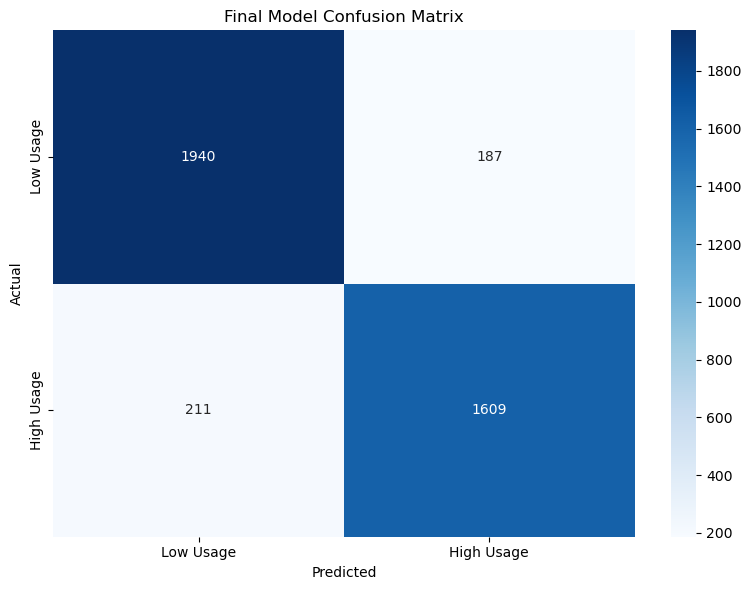

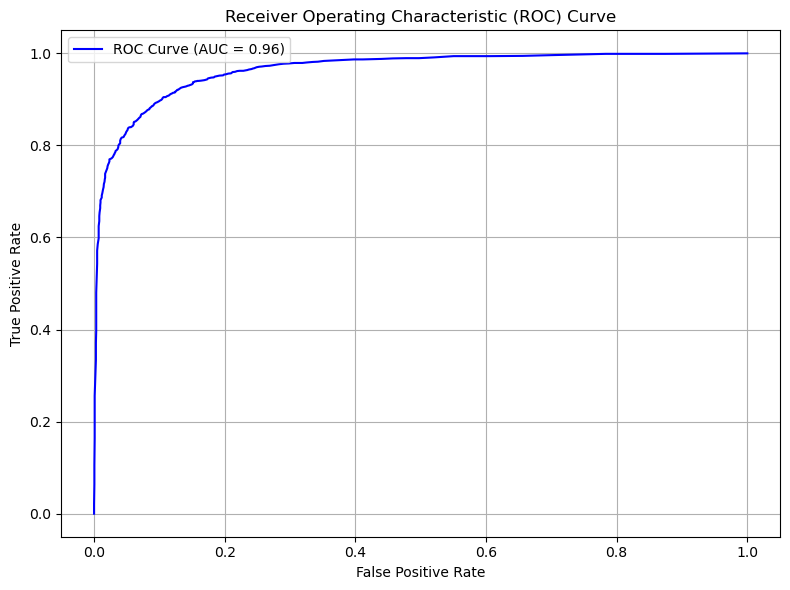

In [44]:
#Traning the final model with the best parameters
from sklearn.metrics import roc_curve, auc
rf_model_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=best_params_new_depth['max_depth'],
    min_samples_split=best_params_new_split['min_samples_split'],
    min_samples_leaf=best_params_new_leaf['min_samples_leaf'],
    max_features=best_params_new_features['max_features'],
    random_state=42
)
rf_model_final.fit(X_new_train, y_new_train)
y_pred_final_new = rf_model_final.predict(X_new_test)
accuracy_final = accuracy_score(y_new_test, y_pred_final_new)
print(f"Final Model Accuracy: {accuracy_final:.3f}")
# Plotting the final model's confusion matrix
cm_final = confusion_matrix(y_new_test, y_pred_final_new)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Usage', 'High Usage'], yticklabels=['Low Usage', 'High Usage'])
plt.title('Final Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

#Plotting the roc curve for the final model
fpr, tpr, thresholds = roc_curve(y_new_test, rf_model_final.predict_proba(X_new_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()




## SVM

SVM Accuracy: 0.774
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      2127
           1       0.76      0.75      0.75      1820

    accuracy                           0.77      3947
   macro avg       0.77      0.77      0.77      3947
weighted avg       0.77      0.77      0.77      3947



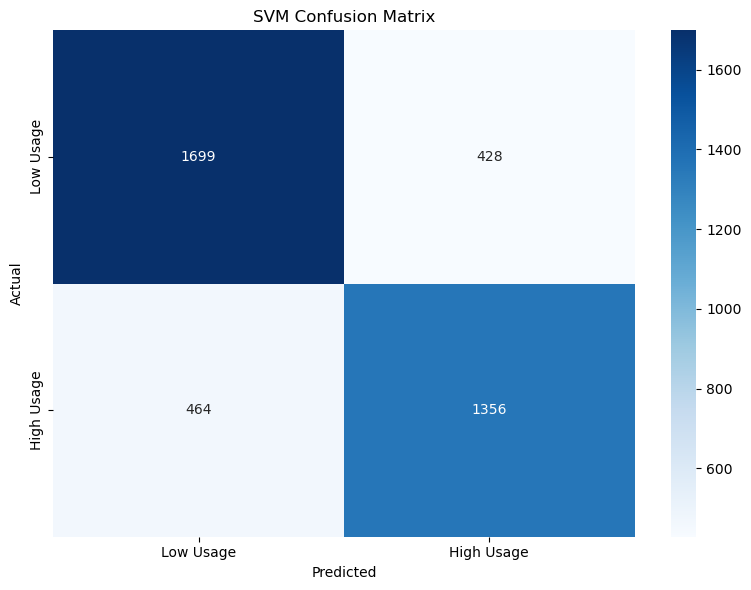

In [45]:
#Naive linear svm classifier
from sklearn.svm import SVC,LinearSVC
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_new_train, y_new_train)
y_pred_svm = svm_model.predict(X_new_test)
# Calculate accuracy and classification report for SVM, and confusion matrix
accuracy_svm = accuracy_score(y_new_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.3f}")
print("SVM Classification Report:")
print(classification_report(y_new_test, y_pred_svm))
# Plot confusion matrix for SVM
cm_svm = confusion_matrix(y_new_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Usage', 'High Usage'], yticklabels=['Low Usage', 'High Usage'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


As expected from the pairplot, we obtain a really low accuracy? Let's try tuning our svm via the kernelt trick and see if we can actually raise it.

In [46]:
#Optimizing the SVM model with grid search, first the kernel
from sklearn.model_selection import GridSearchCV
param_grid_kernel = {
    'kernel': ['linear', 'rbf', 'poly'],
    
}
grid_search_kernel = GridSearchCV(estimator=SVC(random_state=42), param_grid=param_grid_kernel, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_kernel.fit(X_new_train, y_new_train)
best_params_kernel = grid_search_kernel.best_params_
print(f"Best kernel for SVM: {best_params_kernel['kernel']}")


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best kernel for SVM: rbf


In [47]:
#Now optimizing C and gamma all together to avoid overfitting
param_grid_C_gamma = {
    'C': [0.1, 1, 10, 100], 'gamma': ['scale', 0.01,0.1, 1, 10]
}
grid_search_C = GridSearchCV(estimator=SVC(kernel=best_params_kernel['kernel'], random_state=42), param_grid=param_grid_C_gamma, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_C.fit(X_new_train, y_new_train)
best_params_C = grid_search_C.best_params_
print(f"Best C for SVM: {best_params_C['C']}")
print(f"Best gamma for SVM: {best_params_C['gamma']}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best C for SVM: 100
Best gamma for SVM: scale


Final SVM Model Accuracy: 0.880
Final SVM Classification Report:               precision    recall  f1-score   support

           0       0.88      0.91      0.89      2127
           1       0.89      0.85      0.87      1820

    accuracy                           0.88      3947
   macro avg       0.88      0.88      0.88      3947
weighted avg       0.88      0.88      0.88      3947



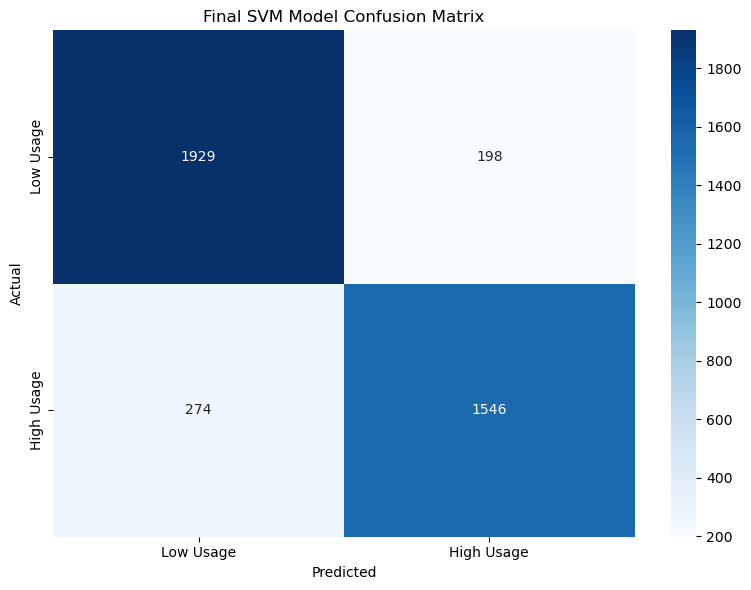

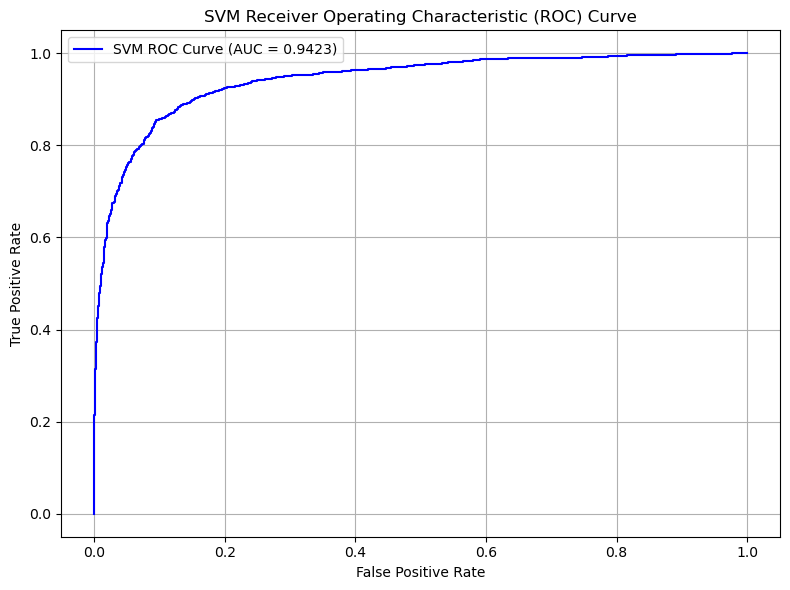

In [48]:
#Fitting with optimal parameters
svm_model_final = SVC(kernel=best_params_kernel['kernel'], C=best_params_C['C'], gamma=best_params_C['gamma'], random_state=42)
svm_model_final.fit(X_new_train, y_new_train)
y_pred_svm_final = svm_model_final.predict(X_new_test)
# Calculate accuracy and classification report for the final SVM model
accuracy_svm_final = accuracy_score(y_new_test, y_pred_svm_final)
classification_report_svm_final = classification_report(y_new_test, y_pred_svm_final)
print(f"Final SVM Model Accuracy: {accuracy_svm_final:.3f}")
print(f"Final SVM Classification Report: {classification_report_svm_final}")
# Plotting the final SVM model's confusion matrix
cm_svm_final = confusion_matrix(y_new_test, y_pred_svm_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm_final, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Usage', 'High Usage'], yticklabels=['Low Usage', 'High Usage'])
plt.title('Final SVM Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
# Plotting the ROC curve for the final SVM model
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_new_test, svm_model_final.decision_function(X_new_test))
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='blue', label=f'SVM ROC Curve (AUC = {roc_auc_svm:.4f})')
plt.title('SVM Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()




Naive SVM Cross-Validation Scores mean: 0.769 ± 0.005
Optimized SVM Cross-Validation Scores mean: 0.878 ± 0.006


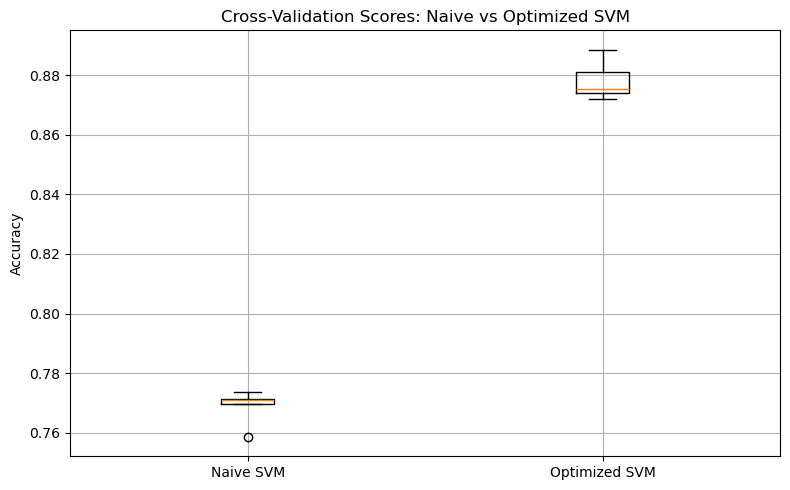

In [50]:
#Comparing cross-validation scores before and after optimization
from sklearn.model_selection import cross_val_score
# Cross-validation scores for the naive SVM model
cv_scores_svm_naive = cross_val_score(svm_model, X_new_train, y_new_train, cv=5, scoring='accuracy')
#Cross-validation scores for the optimized SVM model
cv_scores_svm_optimized = cross_val_score(svm_model_final, X_new_train, y_new_train, cv=5, scoring='accuracy')
print(f"Naive SVM Cross-Validation Scores mean: {cv_scores_svm_naive.mean():.3f} ± {cv_scores_svm_naive.std():.3f}")
print(f"Optimized SVM Cross-Validation Scores mean: {cv_scores_svm_optimized.mean():.3f} ± {cv_scores_svm_optimized.std():.3f}")
# Plotting the cross-validation scores
plt.figure(figsize=(8, 5))
plt.boxplot([cv_scores_svm_naive, cv_scores_svm_optimized], tick_labels=['Naive SVM', 'Optimized SVM'])
plt.title('Cross-Validation Scores: Naive vs Optimized SVM')
plt.ylabel('Accuracy')
plt.grid()
plt.tight_layout()
plt.show()


## kNN

KNN Accuracy: 0.860
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      2127
           1       0.86      0.83      0.84      1820

    accuracy                           0.86      3947
   macro avg       0.86      0.86      0.86      3947
weighted avg       0.86      0.86      0.86      3947



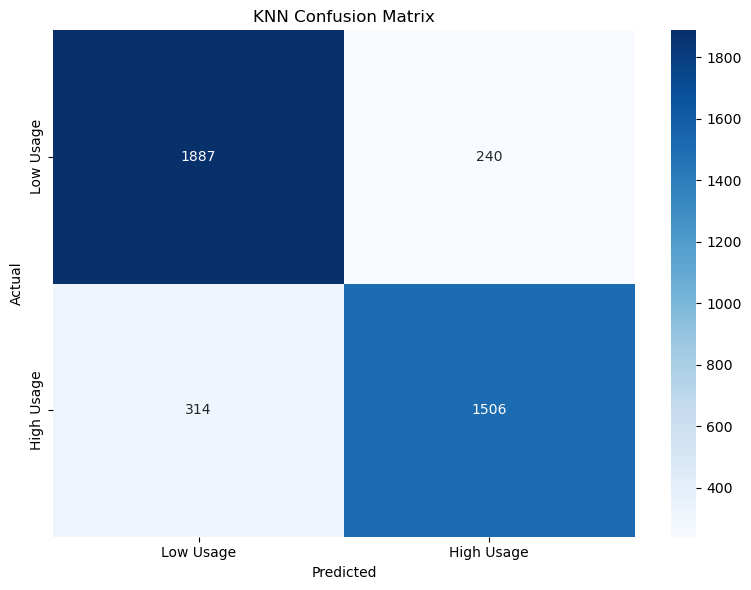

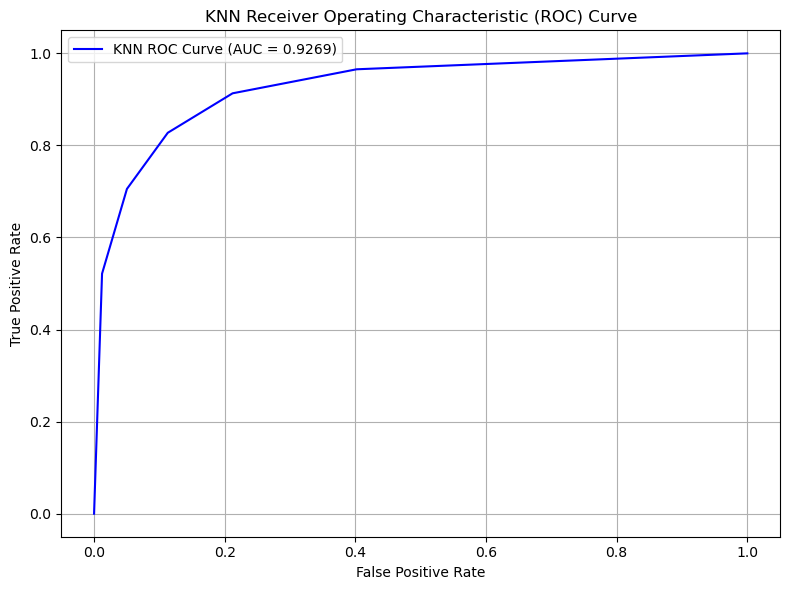

In [51]:
#implementing a naive Knn
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_new_train, y_new_train)
y_pred_knn = knn_model.predict(X_new_test)
# Calculate accuracy and classification report for KNN, and confusion matrix
accuracy_knn = accuracy_score(y_new_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn:.3f}")
print("KNN Classification Report:")
print(classification_report(y_new_test, y_pred_knn))
# Plot confusion matrix for KNN
cm_knn = confusion_matrix(y_new_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Usage', 'High Usage'], yticklabels=['Low Usage', 'High Usage'])
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
#AUC-ROC curve for KNN

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_new_test, knn_model.predict_proba(X_new_test)[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', label=f'KNN ROC Curve (AUC = {roc_auc_knn:.4f})')
plt.title('KNN Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



In [52]:
#Optimizing the KNN model with grid search, first the number of neighbors

param_grid_knn = {
    'n_neighbors': range(1, 21),  # Testing from 1 to 20 neighbors
    'weights': ['uniform', 'distance'],  # Testing both uniform and distance weights
    
}
grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_knn.fit(X_new_train, y_new_train)
best_params_knn = grid_search_knn.best_params_
print(f"Best parameters for KNN: {best_params_knn}")



Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters for KNN: {'n_neighbors': 4, 'weights': 'distance'}


Final KNN Model Accuracy: 0.866
Final KNN Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      2127
           1       0.87      0.84      0.85      1820

    accuracy                           0.87      3947
   macro avg       0.87      0.86      0.87      3947
weighted avg       0.87      0.87      0.87      3947



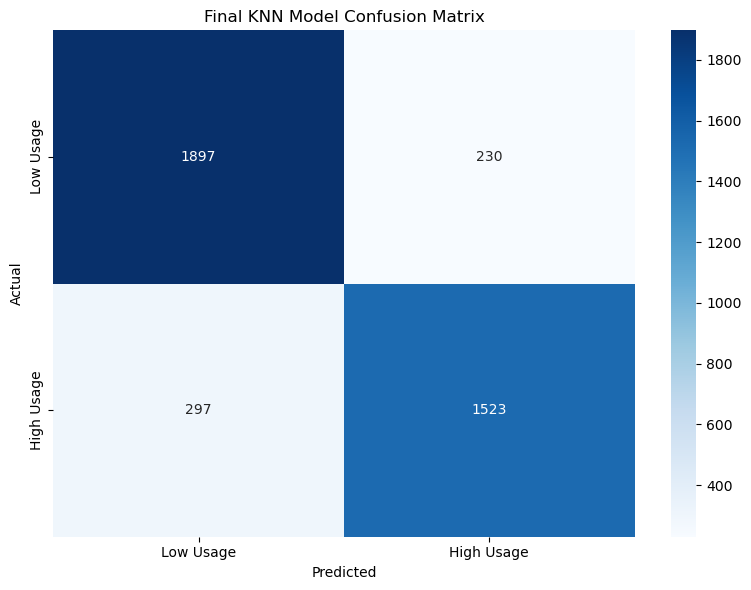

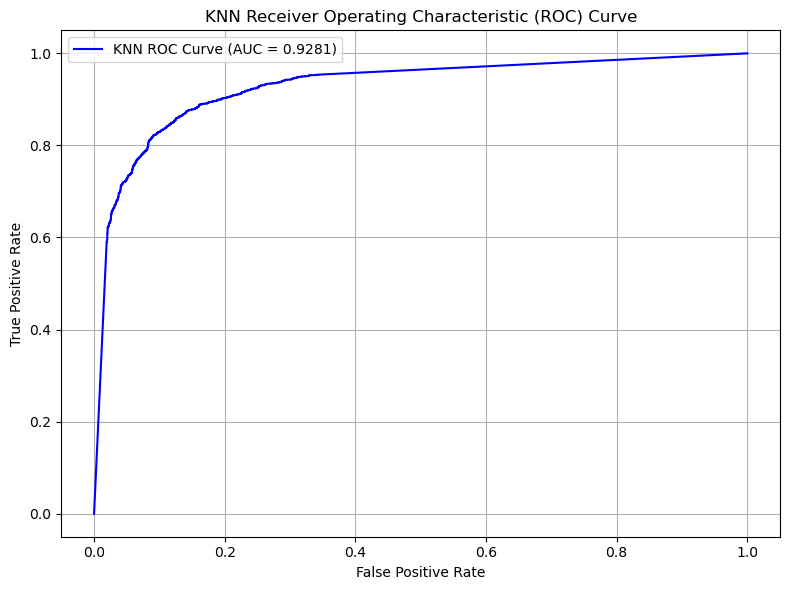

In [53]:
#Fitting the final KNN model with the best parameters
knn_model_final = KNeighborsClassifier(n_neighbors=best_params_knn['n_neighbors'], weights=best_params_knn['weights'])
knn_model_final.fit(X_new_train, y_new_train)
y_pred_knn_final = knn_model_final.predict(X_new_test)
# Calculate accuracy and classification report for the final KNN model
accuracy_knn_final = accuracy_score(y_new_test, y_pred_knn_final)
print(f"Final KNN Model Accuracy: {accuracy_knn_final:.3f}")
print("Final KNN Classification Report:")
print(classification_report(y_new_test, y_pred_knn_final))
# Plotting the final KNN model's confusion matrix
cm_knn_final = confusion_matrix(y_new_test, y_pred_knn_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn_final, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Usage', 'High Usage'], yticklabels=['Low Usage', 'High Usage'])
plt.title('Final KNN Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
# Plotting the ROC curve for the final KNN model
fpr_knn_final, tpr_knn_final, thresholds_knn_final = roc_curve(y_new_test, knn_model_final.predict_proba(X_new_test)[:, 1])
roc_auc_knn_final = auc(fpr_knn_final, tpr_knn_final)
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn_final, tpr_knn_final, color='blue', label=f'KNN ROC Curve (AUC = {roc_auc_knn_final:.4f})')
plt.title('KNN Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Naive KNN Cross-Validation Scores mean: 0.849 ± 0.007
Optimized KNN Cross-Validation Scores mean: 0.858 ± 0.006


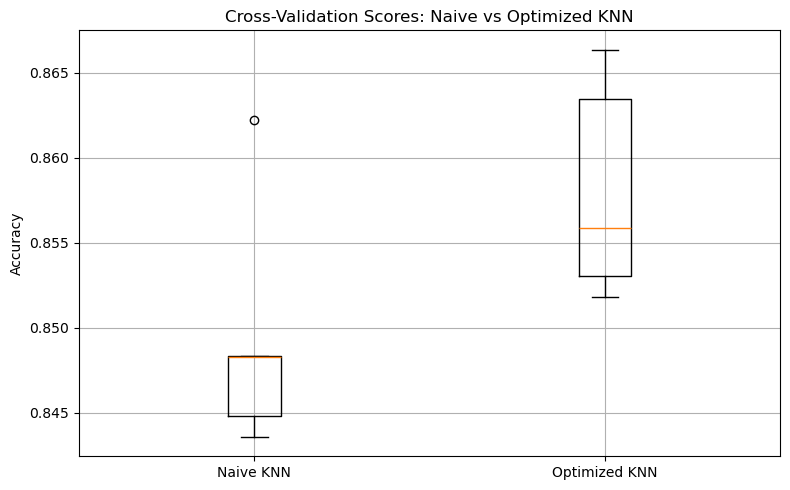

In [55]:
#comparing cross-validation scores before and after optimization for KNN
cv_scores_knn_naive = cross_val_score(knn_model, X_new_train, y_new_train, cv=5, scoring='accuracy')
cv_scores_knn_optimized = cross_val_score(knn_model_final, X_new_train, y_new_train, cv=5, scoring='accuracy')
print(f"Naive KNN Cross-Validation Scores mean: {cv_scores_knn_naive.mean():.3f} ± {cv_scores_knn_naive.std():.3f}")
print(f"Optimized KNN Cross-Validation Scores mean: {cv_scores_knn_optimized.mean():.3f} ± {cv_scores_knn_optimized.std():.3f}")
# Plotting the cross-validation scores for KNN
plt.figure(figsize=(8, 5))
plt.boxplot([cv_scores_knn_naive, cv_scores_knn_optimized], tick_labels=['Naive KNN', 'Optimized KNN'])
plt.title('Cross-Validation Scores: Naive vs Optimized KNN')
plt.ylabel('Accuracy')
plt.grid()
plt.tight_layout()
plt.show()


Despite the optimization, KNN still don't have that good of a result. One reason could be the curse of dimensionality, since as dimension gets high the points tends to all be far away. Let's perform a PCA algorithm and compare the results.

In [57]:
#PCA implementing PCA to reduce dimensionality
from sklearn.decomposition import PCA
pca = PCA(n_components=5)  
pca.fit(X_new_scaled)
X_new_pca = pca.transform(X_new_scaled)
# Train-test split for PCA features
X_new_pca_train, X_new_pca_test, y_new_train, y_new_test = train_test_split(X_new_pca, y_new, test_size=0.2, random_state=42)


Number of components: 1, Explained Variance: 0.3247
Number of components: 2, Explained Variance: 0.5558
Number of components: 3, Explained Variance: 0.6231
Number of components: 4, Explained Variance: 0.6870
Number of components: 5, Explained Variance: 0.7322
Number of components: 6, Explained Variance: 0.7687
Number of components: 7, Explained Variance: 0.8029
Number of components: 8, Explained Variance: 0.8342
Number of components: 9, Explained Variance: 0.8640
Number of components: 10, Explained Variance: 0.8905
Number of components: 11, Explained Variance: 0.9127
Number of components: 12, Explained Variance: 0.9310
Number of components: 13, Explained Variance: 0.9469
Number of components: 14, Explained Variance: 0.9586
Number of components: 15, Explained Variance: 0.9650
Number of components: 16, Explained Variance: 0.9700
Number of components: 17, Explained Variance: 0.9747
Number of components: 18, Explained Variance: 0.9790
Number of components: 19, Explained Variance: 0.9828
Nu

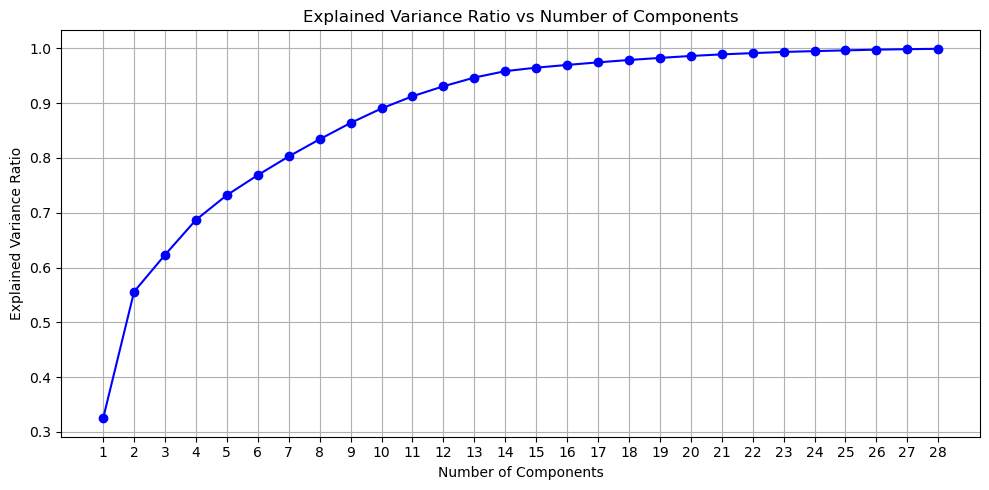

In [59]:
#Choosing how many components to keep based on explained variance
variance=[]
for i in range (1, 29):
    pca = PCA(n_components=i)
    pca.fit(X_new_scaled)
    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"Number of components: {i}, Explained Variance: {explained_variance:.4f}")
    variance.append(explained_variance)
# Plotting the explained variance ratio
plt.figure(figsize=(10, 5))
plt.plot(range(1, 29), variance, marker='o', color='blue')
plt.title('Explained Variance Ratio vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, 29))
plt.grid()
plt.tight_layout()
plt.show()


Text(0.5, 0, 'Number of PCA Components')

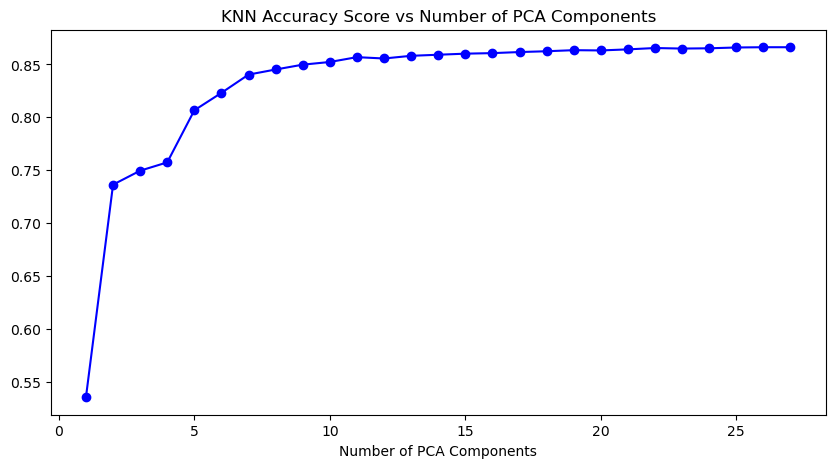

In [60]:
#Let's plot the accuracy of our optimized knn vs number of components
accuracy_pca_scores = []
for i in range(1, 28):
    pca = PCA(n_components=i)
    X_new_pca_transformed = pca.fit_transform(X_new_scaled)
    X_new_pca_train, X_new_pca_test, y_new_train, y_new_test = train_test_split(X_new_pca_transformed, y_new, test_size=0.2, random_state=42)
    
    knn_model_pca = KNeighborsClassifier(n_neighbors=best_params_knn['n_neighbors'], weights=best_params_knn['weights'])
    knn_model_pca.fit(X_new_pca_train, y_new_train)
    y_pred_knn_pca = knn_model_pca.predict(X_new_pca_test)
    
    accuracy_pca = accuracy_score(y_new_test, y_pred_knn_pca)
    accuracy_pca_scores.append(accuracy_pca)
# Plotting the accuracy scores for PCA
plt.figure(figsize=(10, 5))
plt.plot(range(1, 28), accuracy_pca_scores, marker='o', color='blue', label='Accuracy Score')
plt.title('KNN Accuracy Score vs Number of PCA Components')
plt.xlabel('Number of PCA Components')


This plot reveals that, in fact, the problem was not the dimension. Therefore, we will have to accept our mid results.

## Neural network. 
For the sake of speedness, I trained on a google colab gpu. Please see the other jupyter file for this part.